<!-- # TODO

- attach_results bug (possibly resolved)
- add asserts where appropriate
- Add FIFO optimization
- switch to QAT
- add table of contents
- update MNIST tutorial
- put reference design on Zenodo
- add doc comments

- allow user to make 8, 12, or 16 bit
- allow user to select Octo or Quad CXP-12
- include envionrment yml -->

# Part 9: Frame Grabbers

## Table of Contents
- Helpful functions for dataset
- Helpful functions for training
- Make dataset
- Model training
    - Keras model classification performance
- Extensions API for custom layer
- Post-training quantization, compiling an hls4ml model
- HLS model profiling
- Simulate HLS model
    - HLS model classification performance
- FIFO Optimization
- Frame grabber firmware integration
    - Acquisition parameters, network weights, layers, and other
    - C-simulation
    - Frame grabber model classification performance
    - C-synthesis
    - Implementation
    - Benchmarking

This tutorial will cover the training and deployment of YOLO-type neural networks to high-speed frame grabbers, specifically the Euresys Octo and Quad CXP-12. It also covers the hls4ml extensions API, HLS model profiling, and FIFO optimization.

IMPORTANT: Be sure to activate ```hls4ml_frame_grabber``` conda environment (README for instructions on installing).

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import shutil
import os 

import hls4ml
from hls4ml.model.profiling import numerical

import tensorflow as tf
from tensorflow.keras import layers, activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, MaxPooling2D, Activation, Flatten, AveragePooling2D, MaxPool2D, Concatenate, Input
from tensorflow.keras.models import Model

from qkeras.qlayers import QDense, QActivation
from qkeras.qconvolutional import QConv2D
from qkeras.qpooling import QAveragePooling2D
from qkeras.quantizers import quantized_bits, quantized_relu, smooth_sigmoid

2024-06-21 17:53:44.218178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rforelli/miniforge3/envs/hls4ml_frame_grabber/lib/python3.8/site-packages/cv2/../../lib64:/home/rforelli/miniforge3/lib:
2024-06-21 17:53:44.218315: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Helpful functions for dataset

This fake YOLO (FOLO) will have non-standard small pure CNN architecture suitable for deployment to more resource-constrained FPGA devices such these which come equipped with an XCKU035. The dataset will consist of 128x48 frames with MNIST digits randomly inserted throughout. This model and code is adapted from Seachaos' Medium article [here](https://tree.rocks/a-simple-way-to-understand-and-implement-object-detection-from-scratch-by-pure-cnn-36cc28143ca8).

In [2]:
grid_size = 16  # image_size / mask_size
threshold = 0.65
data_size = 100

def make_numbers(X, y): 
    """
    Generates a new data sample by placing random MNIST digits around a 128x48 frame
    
    :param X: New empty FOLO data array
    :param y: New empty FOLO labels data array
    """
    
    for _ in range(3): # place three digits around the image
        
        idx = np.random.randint(len(X_num)) # pick a random digit to insert in frame 
        number = X_num[idx] # grab digit
        kls = y_num[idx]    # grab class
        
        px, py = np.random.randint(0, 100), np.random.randint(0, 20) # generate a random position for the digit
        
        mx, my = (px+14) // grid_size, (py+14) // grid_size # calculate which mask region the digit will belong to
        channels = y[my][mx]

        # prevent duplicates
        if channels[0] > 0:
            continue
            
        channels[0] = 1.0
        channels[1] = px - (mx * grid_size)  # x1
        channels[2] = py - (my * grid_size)  # y1
        channels[3] = 28.0                   # x2
        channels[4] = 28.0                   # y2
        channels[5 + kls] = 1.0
        
        # Insert digit to frame
        X[py:py+28, px:px+28] += number
        
def make_data(size=64):
    """
    Generates a new dataset for FOLO training
    
    :param size: Number of samples to generate for training, can be larger than MNIST dataset
    :return: New dataset and labels
    """

    X = np.zeros((size, 48, 128, 1), dtype=np.float32)  # New data sample of 128x48 images
    y = np.zeros((size, 3, 8, 15), dtype=np.float32)    # New data output consists of probability, bounding box, and class
    
    # Generate data
    for i in range(size): 
        make_numbers(X[i], y[i])
        
    X = np.clip(X, 0.0, 1.0)
    return X, y

def show_predict(X, y, threshold=0.1):
    """
    Display single prediction results
    
    :param X: Data sample input
    :param y: Model predictions
    :param threshold: Probability threshold    
    """
    
    X = X.copy()
    for mx in range(8):
        for my in range(3):
            channels = y[my][mx]
            prob, x1, y1, x2, y2 = channels[:5]

            # if prob < threshold we won't show any thing
            if prob < threshold:
                continue
                                
            color = 255
            # bounding box
            px, py = (mx * grid_size) + x1, (my * grid_size) + y1
            cv2.rectangle(X, (int(px), int(py)), (int(px + x2), int(py + y2)), -1, 1)
            
            # label
            cv2.rectangle(X, (int(px), int(py - 10)), (int(px + 12), int(py)), -1, -1)
            kls = np.argmax(channels[5:])
            cv2.putText(X, f'{kls}', (int(px + 2), int(py-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

            print("digit: " + str(np.argmax(channels[5:15])) + ", prob: " + str(prob) + ", x1: " + str(int(px)) + ", y1: " + str(int(py)) + ", x2: " + str(int(px + x2)) + ", y2: " + str(int(py + y2)))
            
    plt.imshow(X, cmap="gray")

def eval_model_cls_performance(y_pred, y):

    y_pred_flattened = y_pred.reshape(-1, 15)
    filtered_indices = y_pred_flattened[:, 0] > threshold
    filtered_y_pred = y_pred_flattened[filtered_indices]
    filtered_y = y.reshape(-1, 15)[filtered_indices]

    predicted_labels_y_pred = np.argmax(filtered_y_pred[:, 5:15], axis=1)
    predicted_labels_y = np.argmax(filtered_y[:, 5:15], axis=1)

    return predicted_labels_y_pred, predicted_labels_y    


## Helpful functions for training

In [3]:
idx_p = [0] # probability
idx_bb = [1, 2, 3, 4] # bounding box
idx_cls = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14] # class

@tf.function
def loss_bb(y_true, y_pred):
    y_true = tf.gather(y_true, idx_bb, axis=-1)
    y_pred = tf.gather(y_pred, idx_bb, axis=-1)

    loss = tf.keras.losses.mean_squared_error(y_true, y_pred)
    return tf.reduce_mean(loss[loss > 0.0])

@tf.function
def loss_p(y_true, y_pred):
    y_true = tf.gather(y_true, idx_p, axis=-1)
    y_pred = tf.gather(y_pred, idx_p, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_cls(y_true, y_pred):
    y_true = tf.gather(y_true, idx_cls, axis=-1)
    y_pred = tf.gather(y_pred, idx_cls, axis=-1)
    
    loss = tf.losses.binary_crossentropy(y_true, y_pred)
    return tf.reduce_sum(loss)

@tf.function
def loss_func(y_true, y_pred):
    return loss_bb(y_true, y_pred) + loss_p(y_true, y_pred) + loss_cls(y_true, y_pred)

opt = tf.keras.optimizers.Adam(learning_rate=0.01)

## Make dataset

In [4]:
(X_num, y_num), _ = tf.keras.datasets.mnist.load_data()
X_num = np.expand_dims(X_num, axis=-1).astype(np.float32) / 255.0

Let's load  take a look at a sample of our data as well as the corrsponding labels

digit: 4, prob: 1.0, x1: 18, y1: 6, x2: 46, y2: 34
digit: 6, prob: 1.0, x1: 66, y1: 19, x2: 94, y2: 47


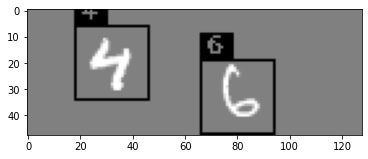

In [5]:
X, y = make_data(size=data_size)
show_predict(X[0], y[0])

## Model training

In [6]:
def FOLO_conv():
    """
    FOLO model architecture using standard Keras layers.

    :return: Keras model
    """
    
    inputs = Input(shape=(48, 128, 1), name='input_1')

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation='relu')(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Output layers
    x_prob = Conv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid')(x)
    x_boxes = Conv2D(4, kernel_size=3, padding='same', name='x_boxes', activation='linear')(x)
    x_cls = Conv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid')(x)

    # Applying gate
    gate = tf.where(x_prob > 0.5, tf.ones_like(x_prob), tf.zeros_like(x_prob))
    x_boxes = x_boxes * gate
    x_cls = x_cls * gate

    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])

    model = Model(inputs, x)
    return model

In [7]:
model = FOLO_conv()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 128, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 64, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 64, 16)  64          ['max_pooling2d[0][0]']      

2024-06-21 17:53:47.062944: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/rforelli/miniforge3/envs/hls4ml_frame_grabber/lib/python3.8/site-packages/cv2/../../lib64:/home/rforelli/miniforge3/lib:
2024-06-21 17:53:47.062971: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-06-21 17:53:47.062996: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (correlator2.fnal.gov): /proc/driver/nvidia/version does not exist
2024-06-21 17:53:47.063191: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebui

In [8]:
model.compile(loss=loss_func, optimizer=opt)

In [9]:
# Uncomment below to enable training
# batch_size = 32
# X_train, y_train = make_data(size=batch_size * 400)
# model.fit(X_train, y_train, batch_size=batch_size, epochs=30, shuffle=True)

In [10]:
# model.save_weights('weights/folo_weights.h5')
model.load_weights('weights/folo_weights.h5') # Load if you would like to skip training

### Keras model classification performance

Lets get an idea of how the model is performing. We expect this model to perform worse than standard MNIST classifiers as digits are allowed to overlap and are more likely to do so at smaller resolutions in cases such as this.

digit: 4, prob: 0.9994048, x1: 20, y1: 7, x2: 47, y2: 33
digit: 6, prob: 0.9979204, x1: 69, y1: 21, x2: 94, y2: 46


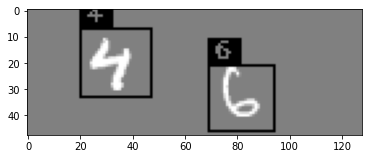

In [11]:
keras_y_pred = model.predict(X)
show_predict(X[0], keras_y_pred[0], threshold=threshold)

In [12]:
keras_y_pred_ex, y_ex = eval_model_cls_performance(keras_y_pred, y)
FOLO_accuracy_keras = np.mean(keras_y_pred_ex == y_ex) * 100
print(f'FOLO classification accuracy: {FOLO_accuracy_keras:.2f}%')

FOLO classification accuracy: 77.01%


## Extensions API for custom layer

The extensions API enables hls4ml users to implement custom layers in their model given the HLS implementation of the layer which is inserted to the HLS model. In this example, the custom layer we are inserting is not utilized during training but is actually for data reduction in hardware. The current model output is of shape (8,3,15) which can be reduced to twenty-four 31-bit values denoting a probability gated to a 1 or 0, four 7 and 6-bit bounding box coordinates, and a 4-bit class. The implementation for this layer is included in ``nnet_reduce.h``

In [13]:
class KReduce(tf.keras.layers.Layer):
    '''Keras implementation of custom layer'''
    
    def __init__(self):
        super().__init__()

    def call(self, inputs):
        # inputs: a tensor of shape(8,3,15)            
        return inputs[:, :, :, 0] # We want our hardware model output to be of shape (1,8,3,1)

class HReduce(hls4ml.model.layers.Layer):
    '''hls4ml implementation of custom layer'''

    def initialize(self):
        inp = self.get_input_variable()
        shape = list(inp.shape)
        shape[-1] = 1 # new output shape is (1,8,3,1)
        
        dims = ['OUT_HEIGHT_{}'.format(self.index), 'OUT_WIDTH_{}'.format(self.index), 'N_FILT_{}'.format(self.index)]
        
        self.add_output_variable(shape, dims)

def parse_reduce_layer(keras_layer, input_names, input_shapes, data_reader):
    '''Parser for converter'''
    
    layer = {}
    layer['class_name'] = 'HReduce'
    layer['name'] = keras_layer['config']['name']
    layer['n_in'] = input_shapes[0][1]*input_shapes[0][2]
    layer['grid_size'] = grid_size
    outshape = [[None, 3, 8]]

    if input_names is not None:
        layer['inputs'] = input_names

    return layer, outshape

# HLS model layer configuration
red_config_template = """struct config{index} : nnet::reduce_config {{
    static const unsigned n_in = {n_in};
    static const unsigned grid_size = {grid_size};
}};\n"""

red_function_template ='nnet::reduce<{input_t}, {output_t}, {config}>({input}, {output});'
red_include_list = ['nnet_utils/nnet_reduce.h']

class HReduceConfigTemplate(hls4ml.backends.template.LayerConfigTemplate):
    def __init__(self):
        super().__init__(HReduce)
        self.template = red_config_template

    def format(self, node):
        params = self._default_config_params(node)
        return self.template.format(**params)

class HReduceFunctionTemplate(hls4ml.backends.template.FunctionCallTemplate):
    '''New layer function template'''
    
    def __init__(self):
        super().__init__(HReduce, include_header=red_include_list)
        self.template = red_function_template

    def format(self, node):
        params = self._default_function_params(node)
        return self.template.format(**params)

# Register the converter for custom Keras layer
hls4ml.converters.register_keras_layer_handler('KReduce', parse_reduce_layer)

# Register the hls4ml's IR layer
hls4ml.model.layers.register_layer('HReduce', HReduce)

for backend_id in ['Vivado']:
    # Register the optimization passes (if any)
    backend = hls4ml.backends.get_backend(backend_id)

    # Register template passes for the given backend
    backend.register_template(HReduceConfigTemplate)
    backend.register_template(HReduceFunctionTemplate)

    # Register HLS implementation
    backend.register_source(os.path.abspath("lambda_cpp/nnet_reduce.h"))

Now define the model with the new layer and copy the weights over. This new model will not provide correct results in Python but will in hardware with the addition of the final ``reduce()`` layer

In [14]:
class quantized_relu(quantized_relu):
    ''' Workaround for quantized_relu __name__ not found bug '''
    def __init__(self, W, I):
        super(quantized_relu, self).__init__(W, I)
        self.__name__ = 'quantized_relu'

def FOLO_conv_reduce():
    """
    Baby FOLO model architecture with new custom layer
    
    :return: Keras model
    """
    
    tf.compat.v1.reset_default_graph()
    x = inputs = Input(shape=(48, 128, 1), name='input_1')

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(inputs)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    x = Conv2D(16, kernel_size=3, padding='same', kernel_initializer='lecun_uniform', activation="relu")(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Output layers
    x_prob = Conv2D(1, kernel_size=3, padding='same', name='x_prob', activation='sigmoid')(x)
    x_boxes = Conv2D(4, kernel_size=3, padding='same', name='x_boxes', activation='linear')(x)
    x_cls = Conv2D(10, kernel_size=3, padding='same', name='x_cls', activation='sigmoid')(x)
    
    x = Concatenate()([x_prob, x_boxes])
    x = Concatenate()([x, x_cls])

    x = KReduce()(x)

    model = tf.keras.models.Model(inputs, x)
    return model        
    
model_reduce = FOLO_conv_reduce()
model_reduce.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 128, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 128, 16)  160         ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 24, 64, 16)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 24, 64, 16)  64          ['max_pooling2d[0][0]']      

In [15]:
model_reduce.load_weights('weights/folo_weights.h5')

In [16]:
 tf.keras.utils.plot_model(model_reduce)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


## Post-training quantization, compiling an hls4ml model

Here we will compile the HLS representation of our model with the custom layer. Notice we set the output precision to 31 bits as previously described. Weight and result precisions were determined by observing the model profiling plots found in the next section.

In [17]:
def print_dict(d, indent=0):
    """
    Prints dictionary to view hls4ml model config
    
    :return: Keras model
    """

    align = 20
    for key, value in d.items():
        print('  ' * indent + str(key), end='')
        if isinstance(value, dict):
            print()
            print_dict(value, indent+1)
        else:
            print(':' + ' ' * (20 - len(key) - 2 * indent) + str(value)) 

In [18]:
config = hls4ml.utils.config_from_keras_model (model_reduce,
                                                   default_precision = 'ap_fixed<32,16>',
                                                   granularity = 'name')

strategy = "Resource"
tracing = True
rf = 1
OUT_DIR = f'folo_on_frame_grabber'

config["Model"]["Strategy"] = strategy
config["Model"]["ReuseFactor"] = rf
for layer in config["LayerName"]:
    config["LayerName"][layer]["Trace"] = tracing
    
config["LayerName"]["conv2d"]['ReuseFactor'] = 3
config["LayerName"]["conv2d"]["Strategy"] = "Resource"
config["LayerName"]["conv2d"]["Precision"]["weight"] = "ap_fixed<16,4>"
config["LayerName"]["conv2d"]["Precision"]["bias"] = "ap_fixed<8,3>"
config["LayerName"]["conv2d"]["Precision"]["result"] = "ap_fixed<16,4>"

config["LayerName"]["conv2d_relu"]["Precision"]["result"] = "ap_ufixed<16,3>"

config["LayerName"]["max_pooling2d"]["Precision"]["result"] = "ap_ufixed<16,3>"

config["LayerName"]["batch_normalization"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["conv2d_1"]['ReuseFactor'] = 36
config["LayerName"]["conv2d_1"]["Strategy"] = "Resource"
config["LayerName"]["conv2d_1"]["Precision"]["weight"] = "ap_fixed<18,5>"
config["LayerName"]["conv2d_1"]["Precision"]["bias"] = "ap_fixed<15,4>"
config["LayerName"]["conv2d_1"]["Precision"]["result"] = "ap_fixed<16,10>"

config["LayerName"]["conv2d_1_relu"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["max_pooling2d_1"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["batch_normalization_1"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["conv2d_2"]['ReuseFactor'] = 144
config["LayerName"]["conv2d_2"]["Strategy"] = "Resource"
config["LayerName"]["conv2d_2"]["Precision"]["weight"] = "ap_fixed<16,3>"
config["LayerName"]["conv2d_2"]["Precision"]["bias"] = "ap_fixed<9,2>"
config["LayerName"]["conv2d_2"]["Precision"]["result"] = "ap_fixed<16,10>"

config["LayerName"]["conv2d_2_relu"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["max_pooling2d_2"]["Precision"]["result"] = "ap_ufixed<16,9>"

config["LayerName"]["batch_normalization_2"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["conv2d_3"]['ReuseFactor'] = 576
config["LayerName"]["conv2d_3"]["Strategy"] = "Resource"
config["LayerName"]["conv2d_3"]["Precision"]["weight"] = "ap_fixed<18,5>"
config["LayerName"]["conv2d_3"]["Precision"]["bias"] = "ap_fixed<12,5>"
config["LayerName"]["conv2d_3"]["Precision"]["result"] = "ap_fixed<16,10>"

config["LayerName"]["conv2d_3_relu"]["Precision"]["result"] = "ap_ufixed<16,8>"

config["LayerName"]["max_pooling2d_3"]["Precision"]["result"] = "ap_ufixed<16,8>"

config["LayerName"]["batch_normalization_3"]["Precision"]["result"] = "ap_fixed<16,4>"

config["LayerName"]["x_prob"]['ReuseFactor'] = 144
config["LayerName"]["x_prob"]["Strategy"] = "Resource"
config["LayerName"]["x_prob"]["Precision"]["weight"] = "ap_fixed<13,3>"
config["LayerName"]["x_prob"]["Precision"]["bias"] = "ap_fixed<5,3>"
config["LayerName"]["x_prob"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["x_prob_sigmoid"]["Precision"]["result"] = "ap_ufixed<16,0>"

config["LayerName"]["x_boxes"]['ReuseFactor'] = 576
config["LayerName"]["x_boxes"]["Strategy"] = "Resource"
config["LayerName"]["x_boxes"]["Precision"]["weight"] = "ap_fixed<19,5>"
config["LayerName"]["x_boxes"]["Precision"]["bias"] = "ap_fixed<7,5>"
config["LayerName"]["x_boxes"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["x_boxes_linear"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["concatenate"]["Precision"]["result"] = "ap_fixed<16,7>"


config["LayerName"]["x_cls"]['ReuseFactor'] = 1440 
config["LayerName"]["x_cls"]["Strategy"] = "Resource"
config["LayerName"]["x_cls"]["Precision"]["weight"] = "ap_fixed<21,5>"
config["LayerName"]["x_cls"]["Precision"]["bias"] = "ap_fixed<7,3>"
config["LayerName"]["x_cls"]["Precision"]["result"] = "ap_fixed<16,6>"

config["LayerName"]["x_cls_sigmoid"]["Precision"]["result"] = "ap_ufixed<16,0>"

config["LayerName"]["concatenate_1"]["Precision"]["result"] = "ap_fixed<16,7>"

config["LayerName"]["k_reduce"]["Precision"]["result"] = "ap_uint<31>"

print_dict(config)
    
hls_model = hls4ml.converters.convert_from_keras_model(model_reduce,
                                                       hls_config = config,
                                                       io_type = 'io_stream',
                                                       output_dir = OUT_DIR,
                                                       part='xcku035-fbva676-2-e'
                                                       )

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer na

Done


## HLS model profiling

Now we will take a look two very useful types of plots. The first is to compare the precision ranges of our model weights to the precision able to represented by the HLS model's fixed-point precision types. The second compares the model outputs of our HLS model to the Keras model. We will disregard the ``reduce`` layer output since our keras model does not implement that layer. These plots give us a sense of what precisions we should set for each layer to optimize across accuracy and resources. We can tell how closely we've matched the float model but looking at the output layer plot (or in this case second to last), ```concatenate_1```.

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer na

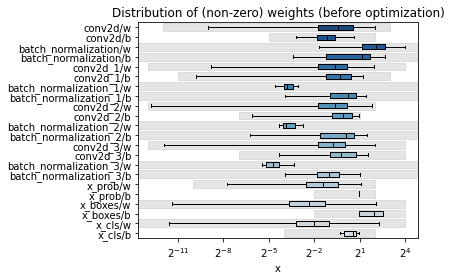

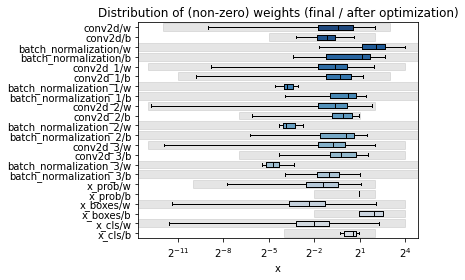

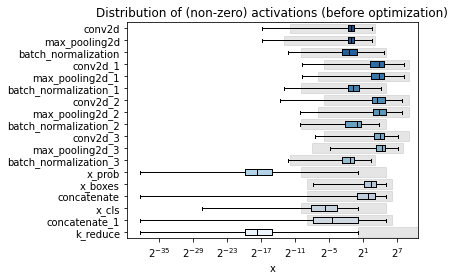

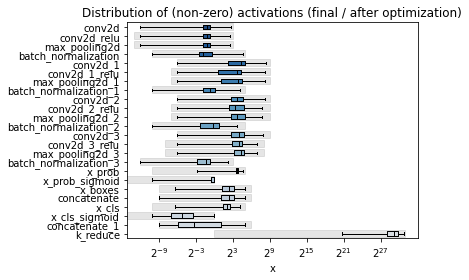

In [19]:
#Compare weights ranges between float and HLS model
X_profile, y_profile = make_data(size=10)
%matplotlib inline
plots = hls4ml.model.profiling.numerical(model=model_reduce, hls_model = hls_model, X=np.ascontiguousarray(X_profile))

Done taking outputs for Keras model.
Recompiling myproject with tracing
Writing HLS project
Done


/tmp/ipykernel_41935/3770013867.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


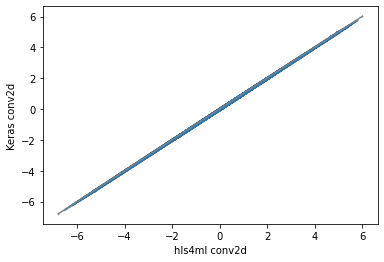

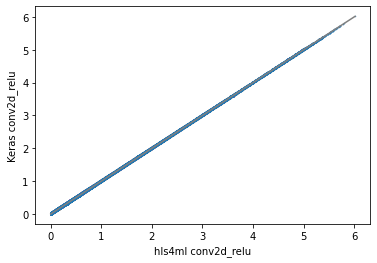

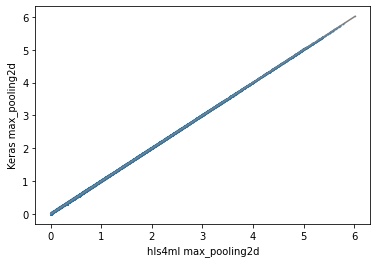

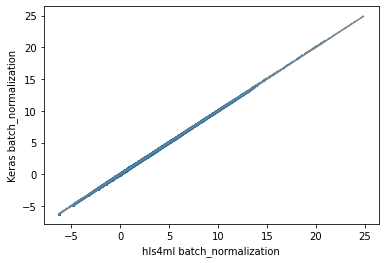

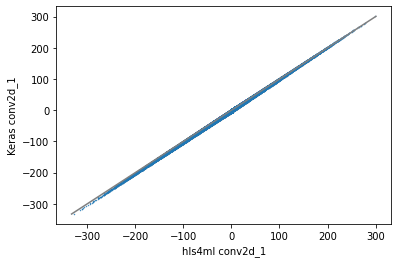

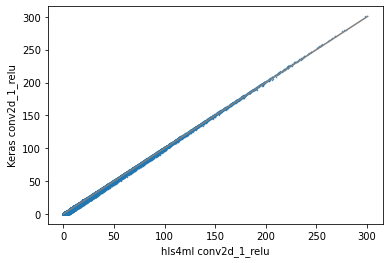

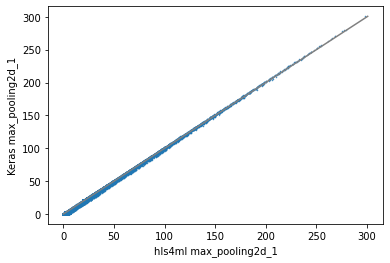

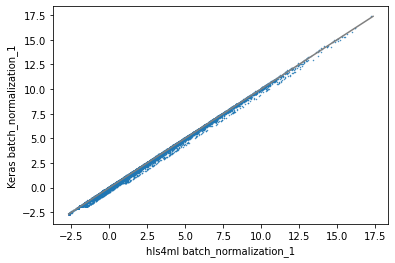

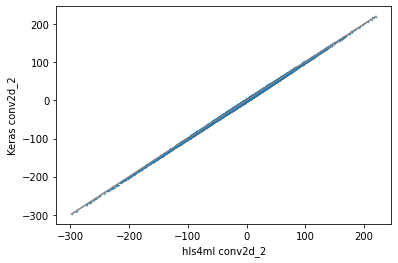

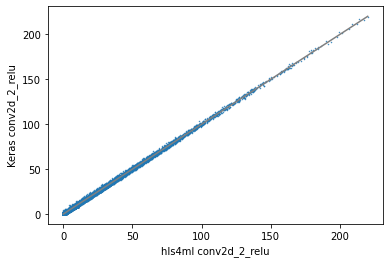

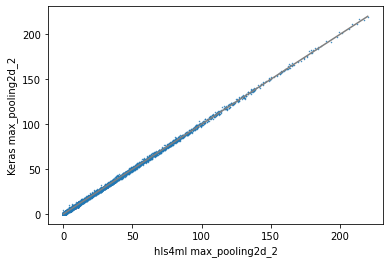

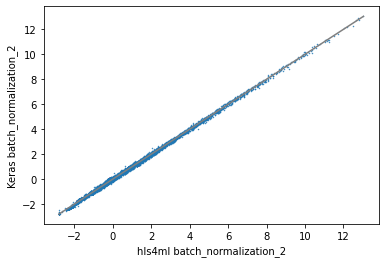

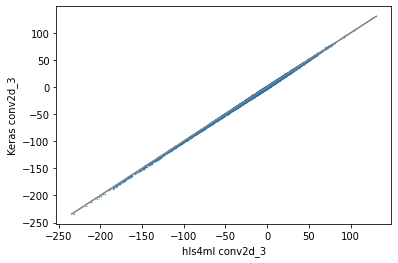

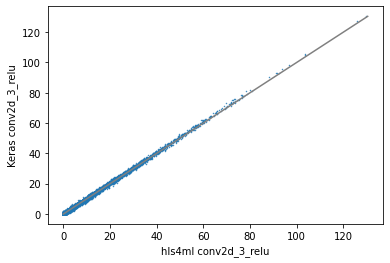

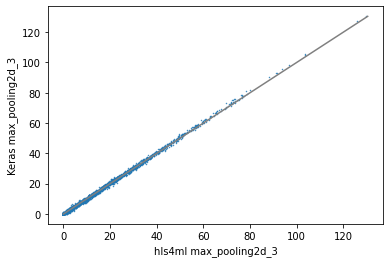

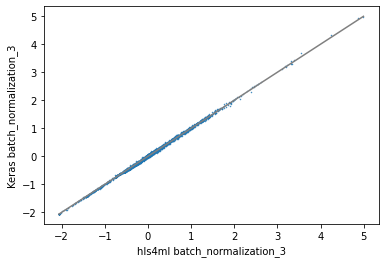

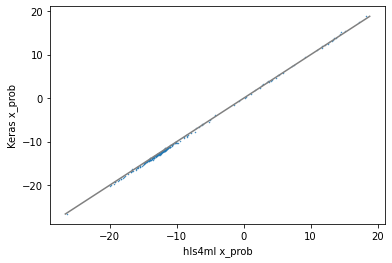

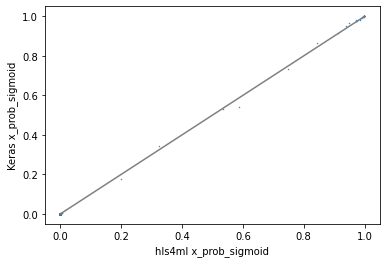

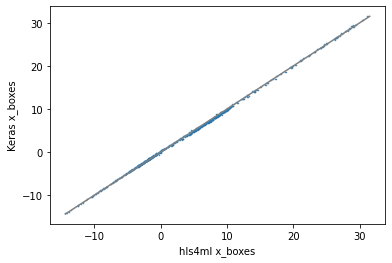

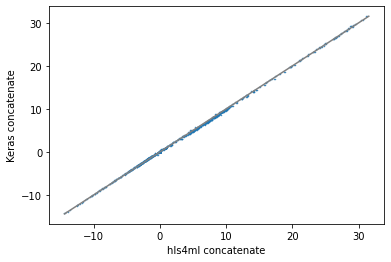

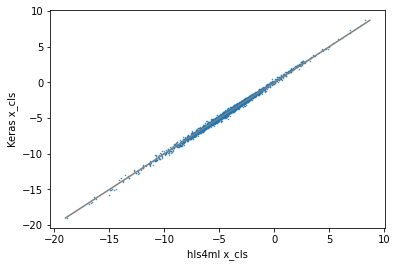

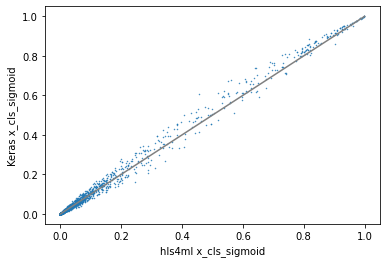

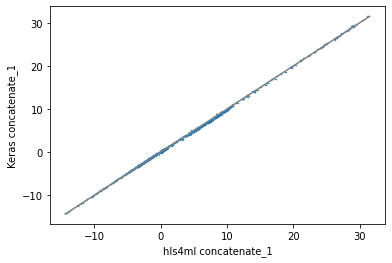

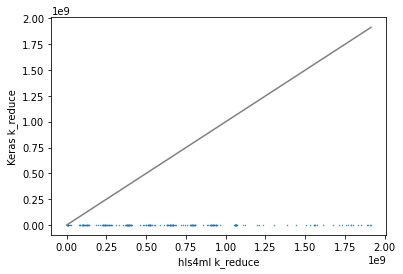

In [20]:
#Trace Model
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model_reduce, np.ascontiguousarray(X_profile))
y_hls, hls4ml_trace = hls_model.trace(np.ascontiguousarray(X_profile))

#Compare layer outputs
for layer in hls4ml_trace.keys():
            plt.figure()
            klayer = layer
            if "_alpha" in layer:
                klayer = layer.replace("_alpha", "")
            if "_linear" in layer:
                klayer = layer.replace("_linear", "")
            plt.scatter(hls4ml_trace[layer].flatten(), keras_trace[klayer].flatten(), s=0.2)
            min_x = min(np.amin(hls4ml_trace[layer]), np.amin(keras_trace[klayer]))
            max_x = max(np.amax(hls4ml_trace[layer]), np.amax(keras_trace[klayer]))
            plt.plot([min_x, max_x], [min_x, max_x], c="gray")
            plt.xlabel("hls4ml {}".format(layer))
            plt.ylabel("Keras {}".format(klayer))

## Simulate HLS model

Before we integrate our neural network into the frame grabber reference design. Lets make sure it's providing solid results by running csim. We will need to save our test data to the testbennch folder

In [21]:
np.savetxt(OUT_DIR + "/tb_data/tb_input_features.dat", X.reshape(X.shape[0], -1), delimiter=' ')
np.savetxt(OUT_DIR + "/tb_data/tb_output_predictions.dat", np.zeros(y.shape[0:3]).reshape(y.shape[0], -1), delimiter=' ') # no need to save true y's since we have to parse bitstring outputs

In [22]:
hls_model.build(csim=True, synth=False, cosim=False, validation=False, vsynth=False, fifo_opt=False, export=False)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /data1/rforelli/Xilinx_2018/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/data1/rforelli/Xilinx_2018/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rforelli' on host 'correlator2.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Fri Jun 21 17:54:39 CDT 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber'
INFO: [HLS 200-10] Creating and opening project '/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO: [HLS 200-10

{'CSimResults': [['8131641',
   '100816025',
   '243444964',
   '402707529',
   '520294505',
   '646143161',
   '796891241',
   '931125337',
   '1580345',
   '143561124',
   '1242480148',
   '370984249',
   '547183137',
   '572478977',
   '781816121',
   '916183401',
   '1060900425',
   '104222249',
   '263751145',
   '373083721',
   '548357734',
   '1655274214',
   '784171545',
   '918410857'],
  ['135257',
   '134505673',
   '235050151',
   '394186841',
   '536944759',
   '620979475',
   '797020217',
   '947902537',
   '1075732057',
   '111052345',
   '1208662601',
   '387502361',
   '546785717',
   '1636399603',
   '782079337',
   '916183401',
   '3033737',
   '36464313',
   '264007081',
   '398250553',
   '515183125',
   '665931209',
   '792435289',
   '918410857'],
  ['17045607',
   '151160087',
   '1241693634',
   '352501865',
   '554122501',
   '620845236',
   '796760167',
   '931124313',
   '1075472995',
   '34892293',
   '202281267',
   '379243817',
   '1602708949',
   '613632

In [23]:
hls_predictions = np.genfromtxt(OUT_DIR + "/tb_data/csim_results.log", delimiter=' ')

In [24]:
def bit_range(num, end_idx, start_idx):
    """
    Extracts bit range from integer
    
    :param num: Number from which to extract bits
    :param end_idx: Ending index (inclusive) from the right in the binary representation
    :param start_idx: Starting index (inclusive) from the right in the binary representation
    :return: Extracted bit range as an integer
    """
    
    mask = ((1 << (end_idx + 1)) - 1) - ((1 << start_idx) - 1)
    return (num & mask) >> start_idx

def one_hot_encode(digit):
    """
    One-hot encode a digit into a 10-element vector.
    
    :param digit: Digit to encode
    :return: encoding
    """
    
    encoding = np.zeros(10, dtype=int)
    encoding[digit] = 1
    return encoding

def show_predict_hardware(X, y):
    """
    Display single prediction results from the hardware (parsed from the output bit strings)
    
    :param X: Data sample input
    :param y: Model predictions
    """
    
    X = X.copy()
    channels = np.zeros((6), dtype=np.uint64)
    
    for i in range(24):
        channels[0] = bit_range(int(y[i]), 30, 30)
        channels[1] = bit_range(int(y[i]), 29, 23)
        channels[2] = bit_range(int(y[i]), 22, 17)
        channels[3] = bit_range(int(y[i]), 16, 10)
        channels[4] = bit_range(int(y[i]), 9, 4)
        channels[5] = bit_range(int(y[i]), 3, 0)
        
        if channels[0] < 1:
            continue

        color = 255
        # bounding box
        cv2.rectangle(X, (channels[1], channels[2]), (channels[3], channels[4]), -1, 1)

        print("digit: " + str(channels[5]) + ", prob: " + str(channels[0]) + ", x1: " + str(int(channels[1])) + ", y1: " + str(int(channels[2])) + ", x2: " + str(int(channels[3])) + ", y2: " + str(int(channels[4])))

        # label
        cv2.rectangle(X, (int(channels[1]), int(channels[2]-10)), (int(channels[1]+12), int(channels[2])), -1, -1)
        kls = channels[5]
        cv2.putText(X, f'{kls}', (int(channels[1]+2), int(channels[2]-2)), cv2.FONT_HERSHEY_PLAIN, 0.7, (0.0, 0.0, 0.0))

    plt.imshow(X, cmap="gray")

    
def eval_model_cls_performance(y_pred, y):
    """
    Evaluate models class performance
    
    :param y_pred: model predictions 
    :param y: true y
    :return predicted_labels_y_pred: y predicted
    :return predicted_labels_y: y label
    """
    
    y_pred_flattened = y_pred.reshape(-1, 15)
    filtered_indices = y_pred_flattened[:, 0] > threshold
    filtered_y_pred = y_pred_flattened[filtered_indices]
    filtered_y = y.reshape(-1, 15)[filtered_indices]

    predicted_labels_y_pred = np.argmax(filtered_y_pred[:, 5:15], axis=1)
    predicted_labels_y = np.argmax(filtered_y[:, 5:15], axis=1)

    return predicted_labels_y_pred, predicted_labels_y    
    
def create_FOLO_output_from_hardware(input_array):
    """
    Decode FOLO output from hardware
    
    :param input_array: FOLO hardware output 
    :return output_array: decoded FOLO output
    """
    
    output_array = np.zeros((input_array.shape[0]*input_array.shape[1], 15), dtype=int)
    
    idx = 0
    for i in range(input_array.shape[0]):
        for j in range(input_array.shape[1]):
            # First feature: just the first bit
            output_array[idx, 0] = bit_range(int(input_array[i, j]), 30, 30)

            # Subsequent bit ranges
            output_array[idx, 1] = bit_range(int(input_array[i, j]), 29, 23)
            output_array[idx, 2] = bit_range(int(input_array[i, j]), 22, 17)
            output_array[idx, 3] = bit_range(int(input_array[i, j]), 16, 10)
            output_array[idx, 4] = bit_range(int(input_array[i, j]), 9, 4)

            # One hot encoding for MNIST digits
            digit = bit_range(int(input_array[i, j]), 3, 0)
            output_array[idx, 5:15] = one_hot_encode(digit)

            idx += 1
    
    return output_array

digit: 4, prob: 1, x1: 20, y1: 7, x2: 47, y2: 33
digit: 6, prob: 1, x1: 69, y1: 20, x2: 94, y2: 46


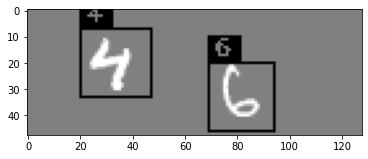

In [25]:
show_predict_hardware(X[0], hls_predictions[0])

### HLS model classification performance

In [26]:
hls_y_pred = create_FOLO_output_from_hardware(hls_predictions)

In [27]:
hls_y_pred_ex, y_ex = eval_model_cls_performance(hls_y_pred, y)
FOLO_accuracy_hls = np.mean(hls_y_pred_ex == y_ex) * 100
print(f'FOLO hls classification accuracy: {FOLO_accuracy_hls:.2f}%')

FOLO hls classification accuracy: 82.17%


## FIFO Optimization

Now we will run a fifo optimization. This process will optimize the depths of the FIFOs used to connect one layer to the next and will save tremendously on BRAM resources. Note that this process requires that we recompile our HLS model which will run c-simulation, c synthesis, and RTL simulation. This process is automated but can take some time. The HLS will automatically be updated with the new FIFO depths.

In [28]:
config['Flows'] = ['vivado:fifo_depth_optimization']
hls4ml.model.optimizer.get_optimizer('vivado:fifo_depth_optimization').configure(profiling_fifo_depth=6_500)

We don't want the FIFO optimization to take to long so let's save only three samples to the testbench

In [29]:
np.savetxt(OUT_DIR + "/tb_data/tb_input_features.dat", X.reshape(X.shape[0], -1)[0:3], delimiter=' ')
np.savetxt(OUT_DIR + "/tb_data/tb_output_predictions.dat", np.zeros(y.shape[0:3]).reshape(y.shape[0], -1)[0:3], delimiter=' ') # no need to save true y's since we have to parse bitstring outputs

In [30]:
hls_model = hls4ml.converters.convert_from_keras_model(model_reduce,
                                                       hls_config = config,
                                                       io_type = 'io_stream',
                                                       output_dir = OUT_DIR,
                                                       part='xcku035-fbva676-2-e'
                                                       )

hls_model.compile()

Interpreting Model
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 1]
Layer name: conv2d, layer type: Conv2D, input shapes: [[None, 48, 128, 1]], output shape: [None, 48, 128, 16]
Layer name: max_pooling2d, layer type: MaxPooling2D, input shapes: [[None, 48, 128, 16]], output shape: [None, 24, 64, 16]
Layer name: batch_normalization, layer type: BatchNormalization, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: conv2d_1, layer type: Conv2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 24, 64, 16]
Layer name: max_pooling2d_1, layer type: MaxPooling2D, input shapes: [[None, 24, 64, 16]], output shape: [None, 12, 32, 16]
Layer name: batch_normalization_1, layer type: BatchNormalization, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer name: conv2d_2, layer type: Conv2D, input shapes: [[None, 12, 32, 16]], output shape: [None, 12, 32, 16]
Layer na

INFO: [HLS 200-489] Unrolling loop 'Result' (firmware/nnet_utils/nnet_dense_resource.h:77) in function 'void nnet::dense_resource_rf_leq_nin<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>(FORWARD_REFERENCE*, FORWARD_REFERENCE*, FORWARD_REFERENCE::weight_t*, FORWARD_REFERENCE::bias_t*)' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'void nnet::shift_line_buffer<nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config16>(FORWARD_REFERENCE const&, ap_shift_reg<FORWARD_REFERENCE::value_type, FORWARD_REFERENCE::in_width> (*) [FORWARD_REFERENCE::n_chan], FORWARD_REFERENCE::value_type*)' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'void nnet::shift_line_buffer<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>

INFO: [XFORM 203-603] Inlining function 'nnet::reduce<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, 2, nnet::Op_max<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0> > >' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (firmware/nnet_utils/nnet_common.h:45->firmware/nnet_utils/nnet_pooling_stream.h:21->firmware/nnet_utils/nnet_pooling_stream.h:204->firmware/nnet_utils/nnet_pooling_stream.h:247->firmware/nnet_utils/nnet_pooling_stream.h:257).
INFO: [XFORM 203-603] Inlining function 'nnet::Op_max<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0> >::operator()' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (firmware/nnet_utils/nnet_common.h:45->firmware/nnet_utils/nnet_pooling_stream.h:21->firmware/nnet_utils/nnet_pooling_stream.h:204->firmware/nnet_

INFO: [XFORM 203-603] Inlining function 'nnet::cast<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>' into 'nnet::dense_resource<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>' (firmware/nnet_utils/nnet_dense_resource.h:79->firmware/nnet_utils/nnet_dense_resource.h:253).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, sigmoid_config19>' (firmware/nnet_utils/nnet_activation_stream.h:90).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>::operator[]' into 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, 

INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:54 ; elapsed = 00:00:56 . Memory (MB): peak = 620.000 ; gain = 196.129 ; free physical = 53634 ; free virtual = 144137
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:59 ; elapsed = 00:01:01 . Memory (MB): peak = 620.000 ; gain = 196.129 ; free physical = 53625 ; free virtual = 144133
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:84) into a 16-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:84) into a 160-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:45) into a 256-bit variable.
INFO: [XFORM 203-1101] Packing variable 'out_data.data.V' (firmware/nnet_utils/nnet_activation_stream.h:45) into a 256-bit variable.
INFO: [XFORM 203-1101] Packing var

INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ConcatLoopWidth' (firmware/nnet_utils/nnet_merge_stream.h:234) in function 'nnet::concatenate3d_2<nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 5u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_fixed<16, 7, (ap_q_mode)5, (ap_o_mode)3, 0>, 15u>, config25>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'CloneLoop' (firmware/nnet_utils/nnet_stream.h:46) in function 'nnet::clone_stream<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, 384>' for pipelining.
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' (firmware/nnet_utils/nnet_conv_stream.h:194:62).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::arr

INFO: [HLS 200-489] Unrolling loop 'Loop-1.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.1' (firmware/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.2.1' (firmware/nnet_utils/nnet_padding_stream.h:22) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.3' (firmware/nnet_utils/nnet_padding_stream.h:11) in fu

INFO: [HLS 200-489] Unrolling loop 'PoolLoop' (firmware/nnet_utils/nnet_pooling_stream.h:198) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' completely with a factor of 4.
INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (firmware/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config16>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (firmware/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 8, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config16>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_s

INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (firmware/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftWidth' (firmware/nnet_utils/nnet_conv_stream.h:194) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftHeight' (firmware/nnet_utils/nnet_conv_stream.h:197) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:199) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config23>' completely with a factor of 16.
INFO: [HLS 200-489] U

INFO: [HLS 200-489] Unrolling loop 'KernelShiftChannel' (firmware/nnet_utils/nnet_conv_stream.h:199) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (firmware/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (firmware/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (firmware/nnet_utils/nnet_conv_stream.h:303) in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 1

INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.16' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.10' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.4' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.22' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.28' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-102] Partitioning array 'res_part.data.V.34' (firmware/nnet_utils/nnet_padding_stream.h:21) automatically.
INFO: [XFORM 203-131] Reshaping array 'w14.V'  in dimension 1 with a block factor of 4.
INFO: [XFORM 203-131] Reshaping array 'w10.V'  in dimension 1 with a block factor of 16.
INFO: [XFORM 203-131] Reshaping array 'w6.V'  in dimension 1 with a block factor

INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.6' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.46' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool_window.V' (firmware/nnet_utils/nnet_pooling_stream.h:178) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'kernel_data.V.6'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 's9.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b9.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 's13.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'b13.V'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V' in dimension 1 completely.
INFO: [

INFO: [XFORM 203-101] Partitioning array 'layer12_out.V.data.V' (firmware/myproject.cpp:103) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer16_out.V.data.V' (firmware/myproject.cpp:123) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer4_out.V.data.V' (firmware/myproject.cpp:63) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer17_out.V.data.V' (firmware/myproject.cpp:127) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer20_out.V.data.V' (firmware/myproject.cpp:159) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer22_out.V.data.V' (firmware/myproject.cpp:163) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.10'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (firmware/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Arra

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:80:61) to (firmware/nnet_utils/nnet_activation_stream.h:80:55) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, sigmoid_config19>'... converting 5 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:80:61) to (firmware/nnet_utils/nnet_activation_stream.h:80:55) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, sigmoid_config24>'... converting 41 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation_stream.h:41:61) to (firmware/nnet_utils/nnet_activation_stream.h:41:55) in function 'nnet::relu<nnet::array<ap_fixed<16, 4, (ap_q_

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource<ap_fixed,ap_fixed<16,7,5,3,0>,config20_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource<ap_fixed,ap_fixed<16,6,5,3,0>,config23_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource<ap_fixed,ap_fixed<16,6,5,3,0>,config18_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource<ap_fixed,ap_fixed<16,4,5,3,0>,config2_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource<ap_fixed,ap_fixed<16,10,5,3,0>,config6_mult>'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (firmware/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource<ap_fixed,ap_fixed<1

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'zeropad2d_cl_array_array_ap_fixed_32_16_5_3_0_1u_config28_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 196.87 seconds; current allocated memory: 980.982 MB.
INFO: [HLS 200-434] Only 0 loops out of a total 4 loops have been pipelined in this design.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.16 seconds; current allocated memory: 981.181 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] --

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.65 seconds; current allocated memory: 1010.034 MB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_ap_fixed_ap_fixed_16_10_5_3_0_config6_mult_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 5.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 5.14 seconds; current allocated memory: 1014.419 MB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
IN

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.95 seconds; current allocated memory: 1.035 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.09 seconds; current allocated memory: 1.037 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s' 
IN

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.2 seconds; current allocated memory: 1.057 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_8_5_3_0_16u_relu_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining loop 'ReLUActLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 3.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.32 seconds; current allocated memory: 1.057 GB.
INFO: [BIND 205-100] Starting micro-architecture generation 

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_1u_config18_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.51 seconds; current allocated memory: 1.072 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.01 seconds; current allocated memory: 1.074 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config

INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.05 seconds; current allocated memory: 1.086 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.59 seconds; current allocated memory: 1.087 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_10u_config23_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.68 seconds; current allocated m

INFO: [RTGEN 206-100] Generating core module 'myproject_mul_14s_32s_46_2_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_16s_32s_48_2_1': 47 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_164_32_1_1': 47 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_42_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_ap_fixed_ap_fixed_16_4_5_3_0_config2_mult_s'.
INFO: [HLS 200-111]  Elapsed time: 0.3 seconds; current allocated memory: 1.129 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_16_4_5_3_0_16u_config2_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_4_5_3_0_16u_config2_s'.
INFO: [HLS 200-111]  

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_Array_V_6_0_14' to 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_ArrayrcU' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_Array_V_6_0_15' to 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s_line_buffer_Arraysc4' due to the length limit 80
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_42_32_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_ufixed_16_3_5_3_0_16u_config4_s'.
INFO: [HLS 200-111]  Elapsed time: 1.3 seconds; current allocated memory: 1.151 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config5_s' 
INFO: [HLS 200-10] ---

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_V_4_1_15' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s_line_buffer_Array_VYie' due to the length limit 80
INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 1.89 seconds; current allocated memory: 1.211 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'dense_resource_ap_fixed_ap_fixed_16_10_5_3_0_config6_mult_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_mul_16s_16s_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mul_mul_18s_16s_34_1_1': 63 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_mux_2568_16_1_1': 63 instance(s)

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 7.14 seconds; current allocated memory: 1.351 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_10_5_3_0_16u_config6_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_10_5_3_0_16u_config6_s'.
INFO: [HLS 200-111]  Elapsed time: 2.03 seconds; current allocated memory: 1.359 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_9_5_3_0_16u_relu_config7_s' 
INFO: [HLS 200-10] -----------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_mux_42_32_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config8_s'.
INFO: [HLS 200-111]  Elapsed time: 1.63 seconds; current allocated memory: 1.367 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config9_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config9_s'.
INFO: [HLS 200-111]  Elapsed time: 2.44 seconds; current allocated memory: 1.377 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config30_s' 
INFO: [HLS 200

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_0_14' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bHp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_1_14' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bIp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_0_15' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bJp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_V_2_1_15' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config10_s_line_buffer_Array_bKp' due to the length limit 80
INFO: [RTGEN 206-100] Finished creat

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 4.18 seconds; current allocated memory: 1.468 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s'.
INFO: [HLS 200-111]  Elapsed time: 1.8 seconds; current allocated memory: 1.476 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_9_5_3_0_16u_relu_config11_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_0' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabLp' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_1' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabMq' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_2' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabNq' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_Array_V_9_0_3' to 'pooling2d_cl_array_array_ap_ufixed_16_9_5_3_0_16u_config12_s_line_buffer_ArrabOq' due to the length limit 80
INFO: [SYN 201-210] Renamed obje

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_0_5' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_cbu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_1_5' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_ccu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_0_6' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_cdu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_V_3_1_6' to 'shift_line_buffer_array_ap_fixed_16_6_5_3_0_16u_config14_s_line_buffer_Array_ceu' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 4.34 seconds; current allocated memory: 1.584 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config14_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config14_s'.
INFO: [HLS 200-111]  Elapsed time: 1.89 seconds; current allocated memory: 1.592 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_array_ap_fixed_16u_array_ap_ufixed_16_8_5_3_0_16u_relu_config15_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206

INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_Array_V_7_0_12' to 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_ArracJz' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_Array_V_7_0_13' to 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_ArracKz' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_Array_V_7_0_14' to 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_ArracLz' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_Array_V_7_0_15' to 'pooling2d_cl_array_array_ap_ufixed_16_8_5_3_0_16u_config16_s_line_buffer_ArracMA' due to the length limit 80
INFO: [RTGEN 206-100] Genera

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_1596_10' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_c8D' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_0_11' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_c9D' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_1596_11' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_daE' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_V_0_12' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config18_s_line_buffer_Array_dbE' due to the length limit 80
INFO: [SYN 201-210] Renamed object nam

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_1u_config18_s'.
INFO: [HLS 200-111]  Elapsed time: 4.29 seconds; current allocated memory: 1.703 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config18_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_1u_config18_s'.
INFO: [HLS 200-111]  Elapsed time: 1.89 seconds; current allocated memory: 1.711 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_array_array_ap_ufixed_16_0_5_3_0_1u_sigmoid_config19_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_V_1_0_0' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_djF' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_V_1_1_0' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_dkF' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_V_1_0_1' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config20_s_line_buffer_Array_dlF' due to the length limit 80
IN

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffer_2d_array_array_ap_fixed_16_7_5_3_0_4u_config20_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------


INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_7_5_3_0_4u_config20_s'.
INFO: [HLS 200-111]  Elapsed time: 4.64 seconds; current allocated memory: 1.795 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_7_5_3_0_4u_config20_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_7_5_3_0_4u_config20_s'.
INFO: [HLS 200-111]  Elapsed time: 1.94 seconds; current allocated memory: 1.804 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'concatenate3d_array_array_array_ap_fixed_16_7_5_3_0_5u_config22_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
I

INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_0_9' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_d7N' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_1_9' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_d8N' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_0_10' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_d9N' due to the length limit 80
INFO: [SYN 201-210] Renamed object name 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_V_8_1_10' to 'shift_line_buffer_array_ap_fixed_16_4_5_3_0_16u_config23_s_line_buffer_Array_eaO' due to the length limit 80
INFO: [SYN 201-210] Renamed object nam

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffer_2d_array_array_ap_fixed_16_6_5_3_0_10u_config23_s'.
INFO: [HLS 200-111]  Elapsed time: 5 seconds; current allocated memory: 1.890 GB.


INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_10u_config23_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_array_ap_fixed_16u_array_ap_fixed_16_6_5_3_0_10u_config23_s'.
INFO: [HLS 200-111]  Elapsed time: 2 seconds; current allocated memory: 1.898 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_array_array_ap_ufixed_16_0_5_3_0_10u_sigmoid_config24_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_array_array_ap_ufixed_16_0_5_3_0_10u_sigmoid_config24_s'.
INFO: [HLS 200-111]  Elapsed time: 1.09 seconds; current allocated memory: 1.901 GB.
INFO: [HLS 

INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_12_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_13_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_14_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer2_out_V_data_15_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_0_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_1_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_5_V_U(fifo_w16_d6500_A)' usin

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_0_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_1_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_5_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_9_V_U(fifo_w16_d6500_A)' using Bl

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_5_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_10_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_11_V_U(fifo_w16_d6500_

INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_10_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_11_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_12_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_13_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_14_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_15_V_U(fifo_w16_d6

INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_10_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_11_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_12_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_13_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_14_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_15_V_U(f

INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_1_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_2_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_3_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_4_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_5_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_6_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_7_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_8_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_9_V_U(fifo_w16_d6500_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'layer25_out_V_data_0_V_U(fifo_w16_d6500_A)

INFO: [RTMG 210-285] Implementing FIFO 'start_for_sigmoid_array_array_ap_ufixed_16_0_5_3_0_10u_sigmoid_config24_U0_U(start_for_sigmoid_array_array_ap_ufixed_16_0_5_3_0_10u_sigmoid_config24_U0)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'start_for_reduce_array_ap_fixed_16_7_5_3_0_15u_array_ap_uint_31_1u_config26_U0_U(start_for_reduce_array_ap_fixed_16_7_5_3_0_15u_array_ap_uint_31_1u_config26_U0)' using Shift Registers.
INFO: [HLS 200-111] Finished generating all RTL models Time (s): cpu = 00:07:02 ; elapsed = 00:07:32 . Memory (MB): peak = 2505.508 ; gain = 2081.637 ; free physical = 51481 ; free virtual = 142304
INFO: [SYSC 207-301] Generating SystemC RTL for myproject.
INFO: [VHDL 208-304] Generating VHDL RTL for myproject.
INFO: [VLOG 209-307] Generating Verilog RTL for myproject.
***** C/RTL SYNTHESIS COMPLETED IN 0h7m12s *****
***** C/RTL SIMULATION *****
INFO: [HLS 200-10] Adding test bench file 'myproject_test.cpp' to the project
INFO: [COSIM 212-47] Using XSI

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config10_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module compute_output_buffer_2d_array_array_ap_fixed_16_10_5_3_0_16u_config10_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module conv_2d_cl_array_array_ap_fixed_16_10_5_3_0_16u_config10_s
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/relu_array_ap_fixed_16u_array_ap_ufixed_16_9_5_3_0_16u_relu_config11_s.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing mod

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/start_for_normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config9epQ.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module start_for_normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config9epQ_shiftReg
INFO: [VRFC 10-311] analyzing module start_for_normalize_array_ap_ufixed_16u_array_ap_fixed_16_6_5_3_0_16u_config9epQ
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/start_for_zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config30_U0.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module start_for_zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config30_U0_shiftReg
INFO: [VRFC 10-311] analyzing module start_for_zeropad2d_cl_array_array_ap_fixed_16_6_5_3_0_16u_config30_U0
INFO: 

Starting static elaboration
Completed static elaboration
Starting simulation data flow analysis
Completed simulation data flow analysis
Time Resolution for simulation is 1ps
Compiling module xil_defaultlib.zeropad2d_cl_array_array_ap_fixe...
Compiling module xil_defaultlib.dense_resource_ap_fixed_ap_fixed...
Compiling module xil_defaultlib.dense_resource_ap_fixed_ap_fixed...
Compiling module xil_defaultlib.myproject_mux_42_32_1_1(ID=1,din...
Compiling module xil_defaultlib.myproject_mux_164_32_1_1(ID=1,di...
Compiling module xil_defaultlib.myproject_mul_16s_32s_48_2_1_Mul...
Compiling module xil_defaultlib.myproject_mul_16s_32s_48_2_1(ID=...
Compiling module xil_defaultlib.myproject_mul_14s_32s_46_2_1_Mul...
Compiling module xil_defaultlib.myproject_mul_14s_32s_46_2_1(ID=...
Compiling module xil_defaultlib.dense_resource_ap_fixed_ap_fixed...
Compiling module xil_defaultlib.shift_line_buffer_array_ap_fixed...
Compiling module xil_defaultlib.shift_line_buffer_array_ap_fixed...
Compiling 

Compiling module xil_defaultlib.AESL_deadlock_detector_1
Compiling module xil_defaultlib.apatb_myproject_top
Compiling module work.glbl
Built simulation snapshot myproject

****** Webtalk v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /home/rforelli/HFG_test/hls4ml-frame-grabbers/folo_on_frame_grabber/myproject_prj/solution1/sim/verilog/xsim.dir/myproject/webtalk/xsim_webtalk.tcl -notrace
INFO: [Common 17-206] Exiting Webtalk at Fri Jun 21 18:11:33 2024...

****** xsim v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source xsim.dir/myproject/xsim_script.tcl
# xsim {myproject} -autoloadwcfg -tclbatch {myproject.tcl}
Vivado Simulator 2018.3
Time resolution is 1 ps
source myproject.tcl
## source "../

INFO: [HLS 200-112] Total elapsed time: 1086.23 seconds; peak allocated memory: 1.931 GB.
INFO: [Common 17-206] Exiting vivado_hls at Fri Jun 21 18:18:17 2024...
Vivado synthesis report not found.
Implementation report not found.
Timing report not found.
[hls4ml] - FIFO optimization completed
Writing HLS project
Done
Writing HLS project
Done


## Frame grabber firmware integration

Now let's begin merging our hls4ml project with the frame grabber reference design. The reference design will embed the model predictions in the first n bits of the corresponding frame where n is the total size of a single model inference output. We only need to copy a few files and portions of the HLS over to the refrerence design ``my-frame-grabber-test_TEMPLATE``.

First let's reference the correct design files for the board we're targetting by setting ``board`` to either "octo" or "quad".

In [31]:
BOARD = "octo" # Insert board name here ("octo" or "quad")

shutil.copytree(f"board_files/{BOARD.lower()}/02_coaxlink", "my-frame-grabber-test_TEMPLATE/02_coaxlink", dirs_exist_ok=True)
shutil.copytree(f"board_files/{BOARD.lower()}/sim", "my-frame-grabber-test_TEMPLATE/04_ref_design/sim", dirs_exist_ok=True)
shutil.copy(f"board_files/{BOARD.lower()}/CustomLogic.h", "my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs")
shutil.copy(f"board_files/{BOARD.lower()}/create_vivado_project.tcl", "my-frame-grabber-test_TEMPLATE/03_scripts")

'my-frame-grabber-test_TEMPLATE/03_scripts/create_vivado_project.tcl'

Now lets copy some files over from our hls4ml project to the reference design

In [32]:
!cp -r {OUT_DIR}/firmware/nnet_utils {OUT_DIR}/firmware/weights {OUT_DIR}/firmware/ap_types {OUT_DIR}/firmware/parameters.h {OUT_DIR}/firmware/defines.h my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs

### Acquisition parameters, network weights, layers, and other

Firstly, lets define some of the acquisition parameters in ``CustomLogic.h``. These parameters include
- ``PIXEL_FORMAT``: Specify your pixel format. Valid values are 8 or 16. If you are recording in 12-bit, write 16 here.
- ``NORM_DIV``: Divide your model's input data by this value for normailzation. In this example we will divide by 255 because we will be recording in Mono8 format.
- ``IMAGE_WIDTH``: Acuisition image width
- ``IMAGE_HEIGHT``: Acuisition image height
- ``CROP_START_X``: If you would like to crop the image input to a specific ROI, specify the start x coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_START_Y``: Specify the crop start y coordinate here. If you do not wish to crop an ROI, set this to 0.
- ``CROP_WIDTH``: Specify the crop width. If you do not wish to crop an ROI, set this equal to the IMAGE_WIDTH.
- ``CROP_HEIGHT``: Specify the crop height. If you do not wish to crop an ROI, set this equal to the IMAGE_HEIGHT.
- ``BLOCK_HEIGHT``: This parameter must be copied from the eGrabber interface. It will be auto-populated and can be found under Data Stream > StreamControl > BlockHeight. Enter it here.

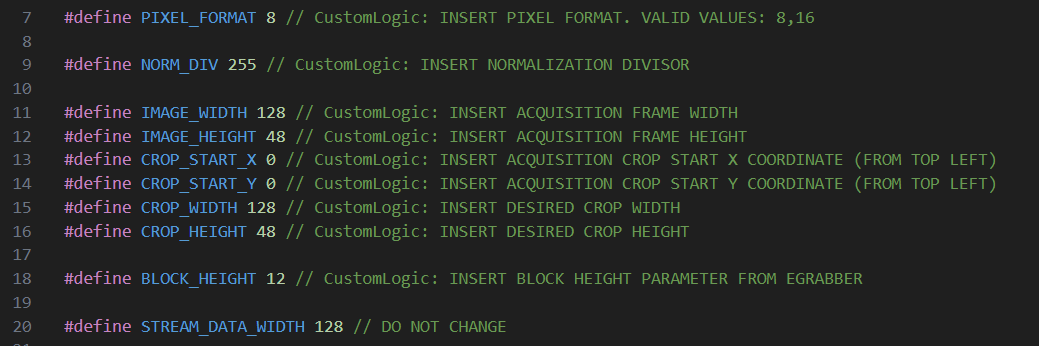

Now, at the bottom of ``CustomLogic.h`` we must enter the striping pattern which the frame grabber will receive out of the camera so the firmware can reoder the data before streaming into the model. Run the cell below to calculate the correct order. You will need to provide your image height and block height.

In [33]:
IMAGE_HEIGHT = 48
BLOCK_HEIGHT = 12

def gen_stripe_pattern(NUM_STRIPES):
    if NUM_STRIPES % 2 != 0:
        print("NUM_STRIPES must be even")
        return None
    
    stripe_order = []
    for i in range(NUM_STRIPES):
        if i % 2 == 0:
            stripe_order.append(((NUM_STRIPES // 2) - (i // 2)) - 1)
        else:
            stripe_order.append(((NUM_STRIPES // 2) + ((i + 1) // 2)) - 1)
    
    return stripe_order

NUM_STRIPES = IMAGE_HEIGHT/(BLOCK_HEIGHT/2)
stripe_order = str(gen_stripe_pattern(int(NUM_STRIPES))).replace('[', '{').replace(']', '}')
print("Copy this array to the strip_order constant in CustomLogic.h: ", stripe_order)

Copy this array to the strip_order constant in CustomLogic.h:  {3, 4, 2, 5, 1, 6, 0, 7}



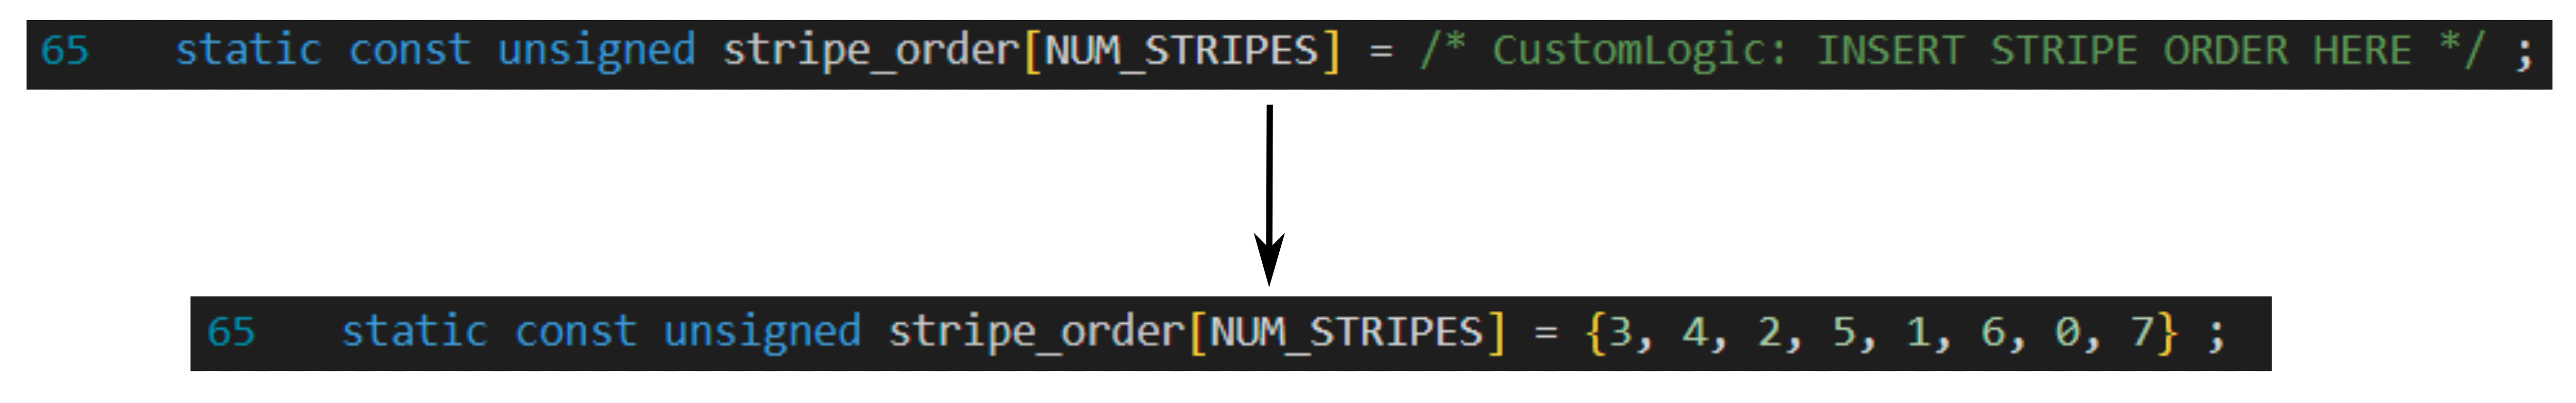

Now we'll begin copying over some HLS from your hls4ml project to the frame grabber template project.

First, set the value of ``MODEL_OUT_DEPTH`` to the depth of your model's output stream. For this FOLO model, we know the output stream will have a depth of 1×8×3=24 based on the shape of our ouput data.

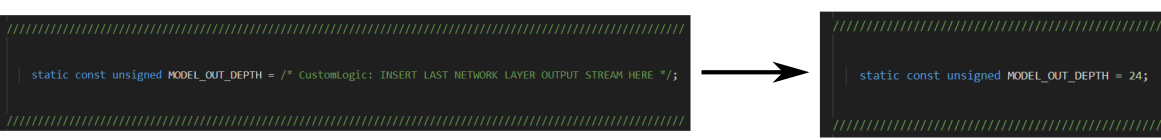

Next, we need to set the depths of the intermediate split input streams ``input_arr_split_reordered`` which reorder the frame input to natural order. Use the output of the cell below.


In [34]:
def generate_pragma_lines(NUM_STRIPES):
    for i in range(NUM_STRIPES):
        print(f'    #pragma HLS STREAM variable=input_arr_split_reordered[{i}] depth=PACKETS_PER_STRIPE')

generate_pragma_lines(int(NUM_STRIPES))  # This will generate 5 lines with incremented indices.


print("\n\nCopy the above HLS to myproject.cpp in the appropriate location")

    #pragma HLS STREAM variable=input_arr_split_reordered[0] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[1] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[2] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[3] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[4] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[5] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[6] depth=PACKETS_PER_STRIPE
    #pragma HLS STREAM variable=input_arr_split_reordered[7] depth=PACKETS_PER_STRIPE


Copy the above HLS to myproject.cpp in the appropriate location


Next, copy your weight import statements to ``myproject.cpp``to the position shown below.

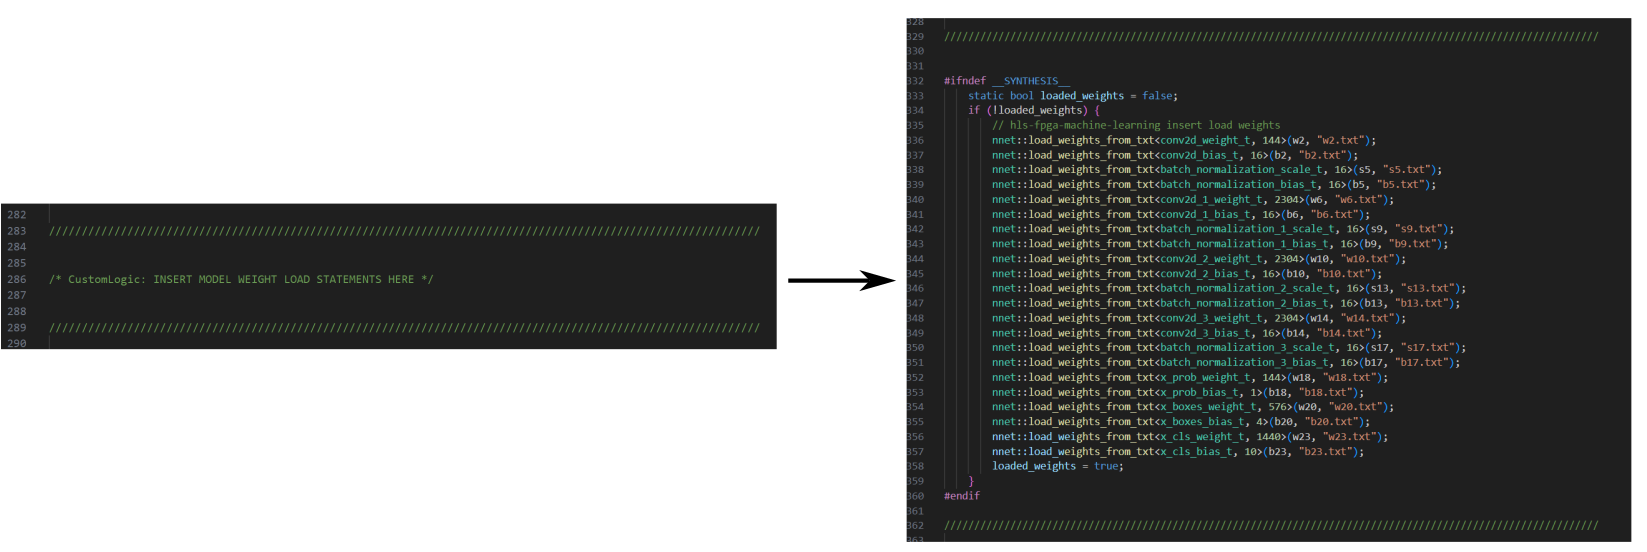

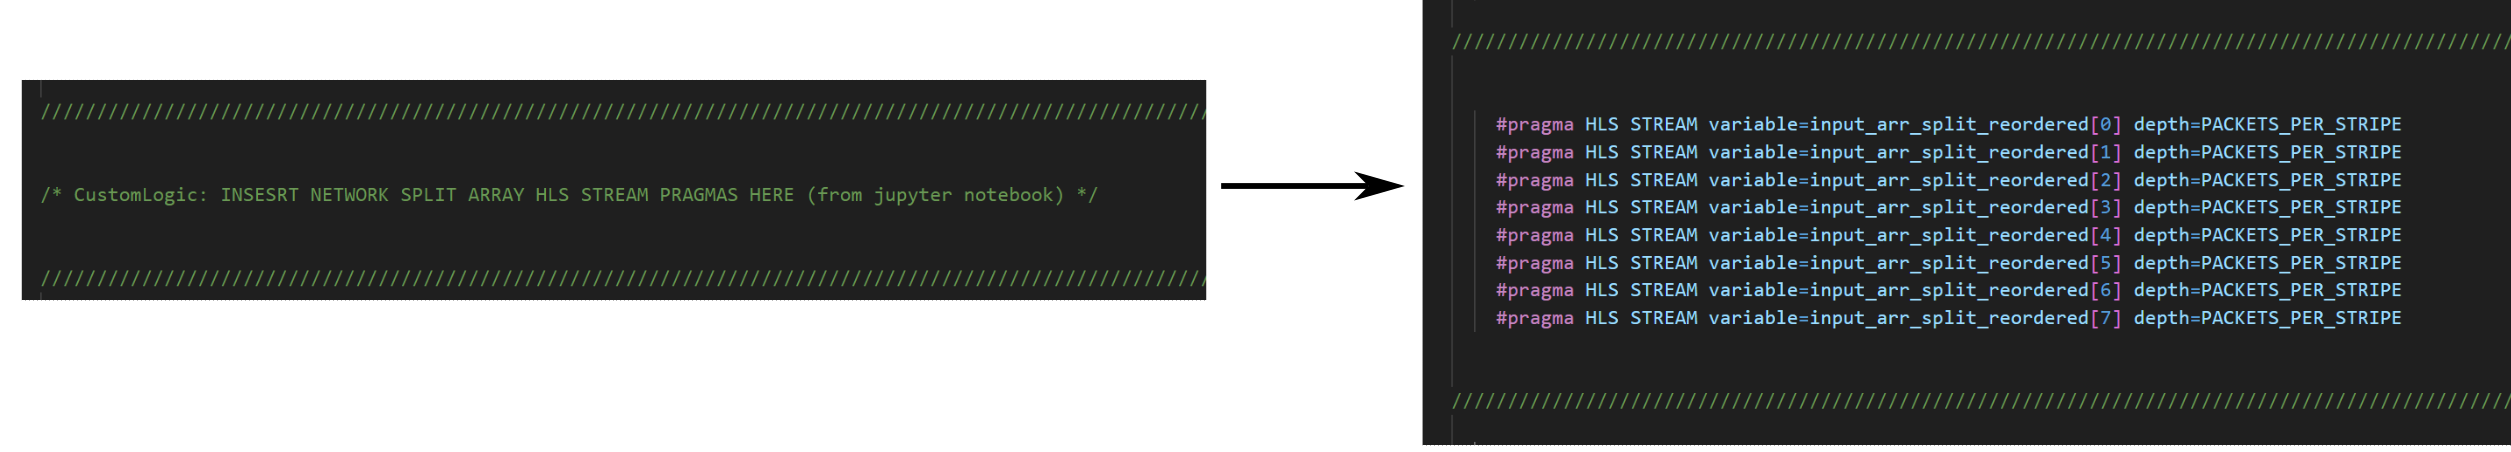

Next, let's copy over the model layers (truncated for viewing, yours may have ``save_layer_output()`` statements interleaved.

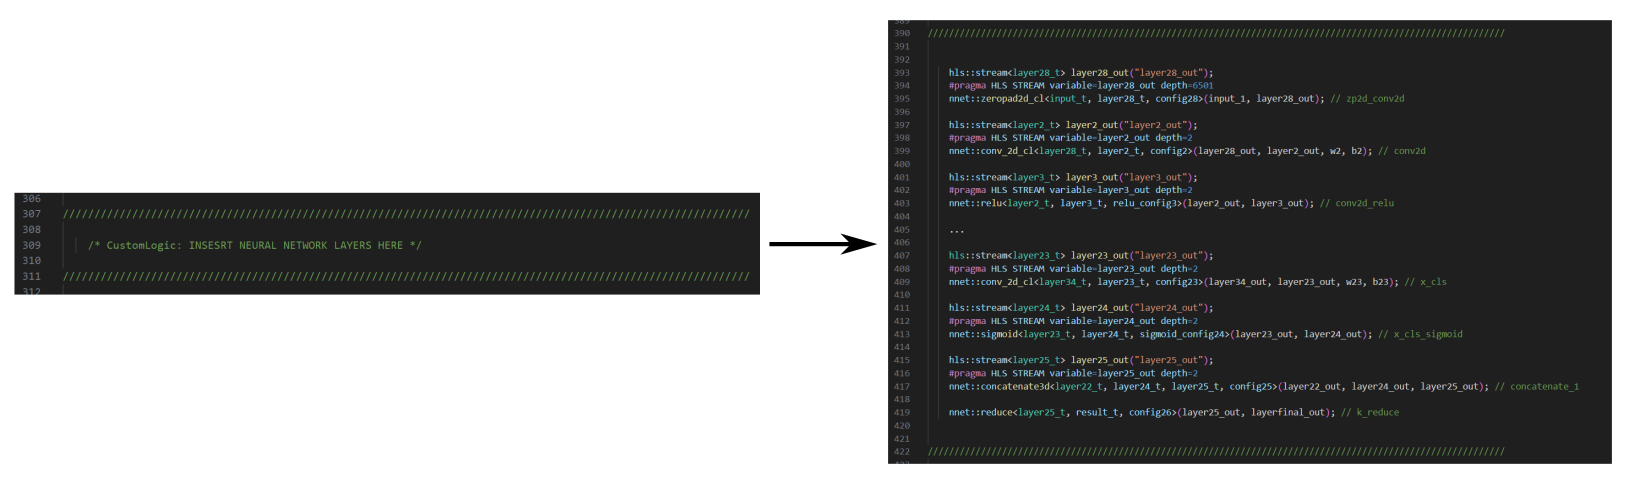

Lastly, we will need to change the name of the model output stream (``layer26_out`` in this case) to ``layerfinal_out``. Your model output stream should be the last stream argument of your networks final layer. ``attach_results()`` will then insert the neural network predictions at the beginning of the image.

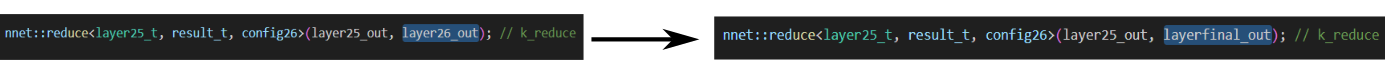

Now, in ``nnet_utils/nnet_helpers.h``, change ``WEIGHTS_DIR`` TO ``../../../../srcs/weights``

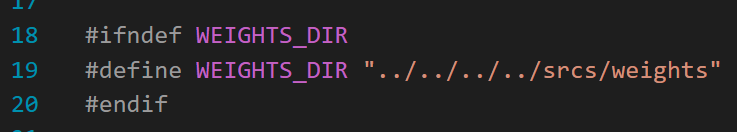

Now, in ``defines.h``, we have to add one include statement, ``#include "CustomLogic.h"``, at the top and one new type definition, ``typedef nnet::array<input_t::value_type, MONOPIX_NBR> input_arr_t;``

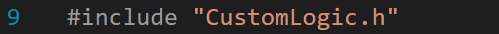

     
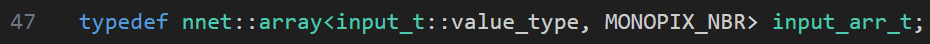
     

### C-simulation

Just like last time, lets save a small dataset to validate our frame grabber firmware with our Keras model via c-simulation.

In [35]:
FRAME_GRABBER_DIR = "my-frame-grabber-test_TEMPLATE/05_model_design_hls"
np.savetxt(FRAME_GRABBER_DIR + "/tb_data/tb_input_features.dat", X.reshape(X.shape[0], -1)*255.0, delimiter=' ', fmt='%d')
np.savetxt(FRAME_GRABBER_DIR + "/tb_data/tb_output_predictions.dat", np.zeros(y.shape[0:3]).reshape(y.shape[0], -1), delimiter=' ')

Now we can execute c-simulation to ensure our frame grabber firmware is producing the expected results

In [37]:
!vivado_hls {FRAME_GRABBER_DIR}/scripts/run_hls.tcl -f "csim=1 synth=0"


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /data1/rforelli/Xilinx_2018/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/data1/rforelli/Xilinx_2018/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rforelli' on host 'correlator2.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Fri Jun 21 18:30:19 CDT 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/home/rforelli/HFG_test/hls4ml-frame-grabbers'
EURESYS_INFO: [Initial path] /home/rforelli/HFG_test/hls4ml-frame-grabbers
EURESYS_INFO: [Script path] /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/scripts
EURESYS_INFO: [Source path] /home/rforelli

1065228409 109206710 235191625 402706505 528292969 662786121 755089766 931251241 9845129 1124636213 1292292569 354208089 496570713 664491320 1812447670 916314489 1035599369 146162089 255233540 389863001 507187801 624640585 817461673 926798409 
Processing input 14
8132681 117332089 243176569 385668201 545855635 671572163 805686632 922872009 1066934633 102259065 228104569 387767656 1562333859 1712563800 1812711912 1922032040 1060901449 104486489 230199897 397989433 506277465 657676809 766867910 960480726 
Processing input 15
7999513 151414950 243580214 352641289 528423001 662658153 788502649 931124313 1712457 119182920 1301205506 1360069224 496960857 647716217 773429625 907793769 4068921 128621250 204377641 372168197 515836489 649812569 775657049 909890137 
Processing input 16
8132681 117332089 251566185 402578521 1577276840 612457705 797289703 922864697 1066934633 102259065 219714937 421069222 1536380502 630554070 1795935763 899534169 1060901449 104486489 221941353 406505977 497888872 6

8002633 1174441336 235569302 410837081 536813673 654267474 797413504 948036729 1447193 118126936 1292820054 354335028 513352057 664496521 1830674096 883020208 1069420089 129385942 255100377 398250569 507187801 666328630 783267446 892855968 
Processing input 46
1056967753 117715991 268995702 419487849 528292953 671046761 788900055 931391687 18762233 1092517573 1327427250 337431945 513480025 655842633 1880354355 856945127 1043601993 120739337 263239257 389862985 507318873 658199097 791775689 934663689 
Processing input 47
8271025 50489670 285516950 385931385 536943714 629505360 797152377 939512889 1193350 1158318550 237289049 362467673 546783654 1669694912 756522377 916314489 1043992137 146040358 1286002416 348044889 515313174 658061782 800690729 910021209 
Processing input 48
16918662 100827476 209754324 394189929 520034425 637487177 797277222 972937241 1082682857 67797460 1233961508 370985273 505093497 647716201 1847715542 908049721 4060585 104223284 263619017 381475433 498799209 64967

16794837 92299473 259953753 385801337 520034425 637620329 788899017 922875127 1099593205 59530613 236622153 379116921 496572793 639323449 1863047625 1930559015 3540437 129391145 247109209 372954713 507057753 624382553 809074102 935183865 
Processing input 78
8132681 117332089 243176569 394188889 536955174 587428201 796758089 947903577 1066934633 102259065 219713913 387373369 1603626546 1628925506 765423881 932962665 1060901449 104486489 221810265 398249513 522670738 589920962 767525444 926799449 
Processing input 79
8132681 117332089 251566201 385800313 520030265 663051430 789153929 948034633 1066934633 102259065 236493177 353950073 530391417 1730127528 1771682409 899536265 1060901449 104486489 238720601 364565081 532355641 665553545 741190276 901631593 
Processing input 80
8132681 117332089 243176553 394581110 537591897 688089241 805932147 956292169 1066934633 93869433 253399369 1419584215 1579116208 639729225 1771947715 907924857 1060901449 95965785 238717481 397601351 514800249 6322

digit: 4, prob: 1, x1: 20, y1: 7, x2: 47, y2: 33
digit: 6, prob: 1, x1: 69, y1: 20, x2: 94, y2: 46


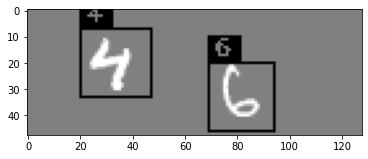

In [38]:
csim_predictions = np.genfromtxt(FRAME_GRABBER_DIR + "/tb_data/csim_results.log", delimiter=' ')
show_predict_hardware(X[0], csim_predictions[0])

### Frame grabber model classification performance

In [39]:
csim_y_pred = create_FOLO_output_from_hardware(csim_predictions)

In [40]:
csim_y_pred_ex, y_ex = eval_model_cls_performance(csim_y_pred, y)
FOLO_accuracy_csim = np.mean(csim_y_pred_ex == y_ex) * 100
print(f'FOLO csim classification accuracy: {FOLO_accuracy_csim:.2f}%')

FOLO csim classification accuracy: 82.17%


### C-synthesis

Now run c-synthesis to generate the RTL representation of our design

In [42]:
!vivado_hls {FRAME_GRABBER_DIR}/scripts/run_hls.tcl -f "csim=0 synth=1"


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /data1/rforelli/Xilinx_2018/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/data1/rforelli/Xilinx_2018/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rforelli' on host 'correlator2.fnal.gov' (Linux_x86_64 version 3.10.0-1160.99.1.el7.x86_64) on Fri Jun 21 18:41:20 CDT 2024
INFO: [HLS 200-10] On os "Scientific Linux release 7.9 (Nitrogen)"
INFO: [HLS 200-10] In directory '/home/rforelli/HFG_test/hls4ml-frame-grabbers'
EURESYS_INFO: [Initial path] /home/rforelli/HFG_test/hls4ml-frame-grabbers
EURESYS_INFO: [Script path] /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/scripts
EURESYS_INFO: [Source path] /home/rforelli

INFO: [HLS 200-489] Unrolling loop 'CastLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:303) in function 'void nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, config18>(FORWARD_REFERENCE const&, ap_shift_reg<FORWARD_REFERENCE::value_type, FORWARD_REFERENCE::in_width> (*) [FORWARD_REFERENCE::n_chan], hls::stream<FORWARD_REFERENCE>&, FORWARD_REFERENCE::weight_t*, FORWARD_REFERENCE::bias_t*)' completely with a factor of 1.
INFO: [HLS 200-489] Unrolling loop 'InitAccum' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:37) in function 'void nnet::dense_resource_rf_leq_nin<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config18_mult>(FORWARD_REFERENCE*, FOR

INFO: [XFORM 203-603] Inlining function 'nnet::kernel_shift_2d<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' into 'nnet::shift_line_buffer<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:252).
INFO: [XFORM 203-603] Inlining function 'nnet::reduce_pool<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, 4, config4>' into 'nnet::compute_pool_buffer_2d<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config4>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:204).
INFO: [XFORM 203-603] Inlining function 'nnet::compute_pool_buffer_2d<nnet::array<ap_ufixed<16, 3, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 3, (ap_q_

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config10>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:237).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>::operator[]' into 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:237).
INFO: [XFORM 203-603] Inlining function 'nnet::kernel_shift_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' into 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' (/home/rforelli/HFG_test/

INFO: [XFORM 203-603] Inlining function 'nnet::compute_pool_buffer_2d<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' into 'nnet::pooling2d_buffer_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:247).
INFO: [XFORM 203-603] Inlining function 'nnet::pooling2d_buffer_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' into 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config8>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_d

INFO: [XFORM 203-603] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>' into 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config10_mult>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:79->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253).
INFO: [XFORM 203-603] Inlining function 'nnet::conv_2d_buffer_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config10>' into 'nnet::conv_2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config10>' (/home/rforelli/HFG_test/hls4ml-frame-

INFO: [XFORM 203-603] Inlining function 'nnet::kernel_shift_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' into 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:252).
INFO: [XFORM 203-603] Inlining function 'nnet::dense_resource_rf_gt_nin_rem0<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config14_mult>' into 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config14_mult>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255).
INFO: [XFORM 203-603] Inlining function 'nnet::cast<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)

INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' into 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:78).
INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' into 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:70).
INFO: [XFORM 203-603] Inlining function 'nnet::fill_zero<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0

INFO: [XFORM 203-603] Inlining function 'nnet::cast<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config23_mult>' into 'nnet::dense_resource<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, config23_mult>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:158->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255).
INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>::operator[]' into 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, config23>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nn

INFO: [XFORM 203-603] Inlining function 'nnet::array<ap_uint<31>, 1u>::operator[].1' into 'nnet::array<ap_uint<31>, 1u>::operator=' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_types.h:29).
INFO: [HLS 200-111] Finished Standard Transforms Time (s): cpu = 00:00:52 ; elapsed = 00:00:54 . Memory (MB): peak = 764.008 ; gain = 340.133 ; free physical = 51792 ; free virtual = 143351
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [XFORM 203-602] Inlining function 'meta_data_proc' into 'myproject_axi' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject_axi.cpp:37) automatically.
INFO: [SYNCHK 200-10] 0 error(s), 1 warning(s).
INFO: [HLS 200-111] Finished Checking Synthesizability Time (s): cpu = 00:00:59 ; elapsed = 00:01:00 . Memory (MB): peak = 767.352 ; gain = 343.477 ; free physical = 51771 ; free virtual = 143335
INFO: [XFORM 203-1101] Packing vari

INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'InputSplitLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:44) in function 'unpack_data' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'FrameLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:110) in function 'read_pixel_data' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'SigmoidActLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:80) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, sigmoid_config24>' for pipelining.
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReLUActLoop' (/home/rforelli/HFG_test/hls4ml-frame-g

INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config20>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:194:62).
INFO: [XFORM 203-502] Unrolling all loops for pipelining in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config18>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:194:62).
INFO: [XFORM 203-502] Unrolling all sub-loops inside loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:129) in function 'nnet::dense_resource<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<16, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, config14_mult>' for pipelining.


INFO: [HLS 200-489] Unrolling loop 'Loop-2.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config30>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.2.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:22) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config30>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-2.3' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad

INFO: [HLS 200-489] Unrolling loop 'Loop-2.3' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'Loop-3.1' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_padding_stream.h:11) in function 'nnet::zeropad2d_cl<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config32>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'SigmoidPackLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:88) in function 'nnet:

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' completely with a factor of 2.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::pooling2d_cl<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config12>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'FiltLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:193) in function

INFO: [HLS 200-489] Unrolling loop 'BatchNormpack' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_batchnorm_stream.h:33) in function 'nnet::normalize<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config9>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'BatchNormpack' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_batchnorm_stream.h:33) in function 'nnet::normalize<nnet::array<ap_ufixed<16, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config13>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'BatchNormpack' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_batchnorm_stream.h:33) in function 

INFO: [HLS 200-489] Unrolling loop 'UpdateBuffer' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:233) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config20>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferDataIn' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:241) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config20>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'LineBufferShift' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:244) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config20>' completely with a facto

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config14>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:303) in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 10, (

INFO: [HLS 200-489] Unrolling loop 'KernelPushHeight' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:210) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 3.
INFO: [HLS 200-489] Unrolling loop 'KernelPushChannel' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:213) in function 'nnet::shift_line_buffer<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, config6>' completely with a factor of 16.
INFO: [HLS 200-489] Unrolling loop 'CastLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:303) in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<32, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_fixed<16, 4, (ap_

INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer34_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:485) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer27_cpy2.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:479) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer33_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:489) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer27_cpy1.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:477) .
INFO: [XFORM 203-102] Automatically partitioning streamed array 'layer32_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-tes

INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.46' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool_window.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:178) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'kernel_data.V.7'  in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:229) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.6' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'tmp.data.V.47' in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'pool_window.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_pooling_stream.h:178) in dime

INFO: [XFORM 203-101] Partitioning array 'input_arr_split_reordered.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:366) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'input_1.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:389) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer28_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:397) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer13_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/myproject.cpp:453) in dimension 1 completely.
INFO: [XFORM 203-101] Partitioning array 'layer31_out.V.data.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPL

INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:229) in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.5'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.4'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.3'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.2'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.1'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'line_buffer.Array.V.8'  in dimension 2 completely.
INFO: [XFORM 203-101] Partitioning array 'shift_buffer.V' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_T

INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:80:61) to (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:80:55) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, nnet::array<ap_ufixed<16, 0, (ap_q_mode)5, (ap_o_mode)3, 0>, 1u>, sigmoid_config19>'... converting 5 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:80:61) to (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_activation_stream.h:80:55) in function 'nnet::sigmoid<nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (a

INFO: [XFORM 203-11] Balancing expressions in function 'nnet::compute_output_buffer_2d<nnet::array<ap_fixed<16, 4, (ap_q_mode)5, (ap_o_mode)3, 0>, 16u>, nnet::array<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, 10u>, config23>' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:286:5)...3 expression(s) balanced.
INFO: [HLS 200-111] Finished Pre-synthesis Time (s): cpu = 00:02:44 ; elapsed = 00:02:46 . Memory (MB): peak = 895.734 ; gain = 471.859 ; free physical = 54720 ; free virtual = 143287

the outer loop is not a perfect loop because there is nontrivial logic before entering the inner loop.

either the parent loop or sub loop is do-while loop.
INFO: [XFORM 203-541] Flattening a loop nest 'ReduceLoopRow' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_reduce.h:23:35) in function 'nnet::reduce<nnet::array<ap_fixed<16, 7, (ap_q_mode

INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource.6'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource.5'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:129) in function 'dense_resource.4'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:43) in function 'dense_resource.3'.
INFO: [XFORM 203-531] Rewinding loop 'ReuseLoop' (/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-t

INFO: [HLS 200-111] Finished Architecture Synthesis Time (s): cpu = 00:03:55 ; elapsed = 00:03:57 . Memory (MB): peak = 1668.008 ; gain = 1244.133 ; free physical = 54012 ; free virtual = 142583
INFO: [HLS 200-10] Starting hardware synthesis ...
INFO: [HLS 200-10] Synthesizing 'myproject_axi' ...
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'read_pixel_data' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	75	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: 

INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 239.1 seconds; current allocated memory: 1.221 GB.
INFO: [HLS 200-434] Only 1 loops out of a total 2 loops have been pipelined in this design.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-archi

INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.46 seconds; current allocated memory: 1.227 GB.
INFO: [BIND 205-100] Starting micro-architect

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'phi' operation ('acc[14].V') with incoming values : ('acc[14].V', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('p_Val2_46_41', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'add' operation ('tmp43', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLA

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'phi' operation ('acc[9].V') with incoming values : ('acc[9].V', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('p_Val2_46_26', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'add' operation ('tmp28', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'phi' operation ('acc[4].V') with incoming values : ('acc[4].V', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('p_Val2_46_11', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'add' operation ('tmp13', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE

###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 32	0	0	263	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'ReuseLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 12.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
IN

INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 4.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimizatio

INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'BatchNormLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 10.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency 

INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 0.76 seconds; current allocated memory: 1.293 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.74 seconds; current allocated memory: 1.294 GB.
INFO: [HLS 200-10] -----------------------------------

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_399', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_52_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_51 = tmp_487_51 * r_V_52
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_395', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_363', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_41_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_40 = tmp_487_40 * r_V_41
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_360', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_327', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_30_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_29 = tmp_487_29 * r_V_30
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_324', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_282', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_16_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_15 = tmp_487_15 * r_V_s
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_278', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_242', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('data_V_load_2_phi', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_16_2 = tmp_487_2 * r_V_2
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_240', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'add' operation ('tmp58', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_388', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'phi' operation ('acc[12].V') with incoming values : ('acc[12].V', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_des

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'partselect' operation ('tmp_352', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_355', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' opera

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'add' operation ('tmp23', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_297', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'phi' operation ('acc[5].V') with incoming values : ('acc[5].V', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_desig

INFO: [SYN 201-351] The following objects are mapped to a ternary adder tree.
   a  'partselect' operation ('tmp_261', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'partselect' operation ('tmp_264', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_mult.h:73->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   c  'partselect' opera

INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.93 seconds; current allocated memory: 1.323 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.39 seconds; current allocated memory: 1.324 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'relu_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 16	0	16	73	32	2	2	2	2	16	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary depen

INFO: [HLS 200-111]  Elapsed time: 1.08 seconds; current allocated memory: 1.327 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.27 seconds; current allocated memory: 1.329 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'normalize' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	57	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ..

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_3' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_872_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_20_14

INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_824_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:253)
  DSP48 Expression: r_V_20_3_i = tmp_515_3_i * r_V_i
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'partselect' operation ('tmp_820_i', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:56->/hom

INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204

INFO: [HLS 200-111]  Elapsed time: 1.17 seconds; current allocated memory: 1.354 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 1.28 seconds; current allocated memory: 1.356 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'normalize_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	57	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints 

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_resource_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SYN 201-351] The following objects are mapped to a DSP48.
   a  'load' operation ('w14_V_load', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255) on array 'w14_V'
   b  'mux' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:139->/home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_dense_resource.h:255)
  DSP48 Express

INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 3	0	1	455	3	3	3	2	2	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latenc

INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'ReadInputHeight_ReadInputWidth'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 5.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating 

INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-61] Pipelining loop 'CloneLoop'.
INFO: [SCHED 204-61] Pipelining result : Target II = 1, Final II = 1, Depth = 2.
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [S

INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.11 seconds; current allocated memory: 1.381 GB.
INFO: [BIND 205-100] Starting micro-architect

INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Pipeline constraints ... 
INFO: [SCHED 204-11] Generating DSP mapping constraints ... 
INFO: [SCHED 204-11] Generating Supporting dependence constraints ... 
INFO: [SCHED 204-11] Generating Resource constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Latency constraints ... 
INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO

INFO: [SCHED 204-11] Generating Cycle time constraints ... 
INFO: [SCHED 204-11] Generating Blocking node constraints ... 
INFO: [SCHED 204-11] Generating Chaining constraints ... 
INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.02 seconds; current allocated memory: 1.391 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring reso

INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
	'call' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:297) to 'dense_resource.4' [623]  (2.4 ns)
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.4 seconds; current allocated memory: 1.395 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INF

INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.01 seconds; current allocated memory: 1.399 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.79 seconds; current allocated memory: 1.400 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing

INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
	'call' operation ('tmp', /home/rforelli/HFG_test/hls4ml-frame-grabbers/my-frame-grabber-test_TEMPLATE/05_model_design_hls/srcs/nnet_utils/nnet_conv_stream.h:297) to 'dense_resource.5' [635]  (2.36 ns)
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.55 seconds; current allocated memory: 1.404 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 20

INFO: [SCHED 204-11] Generating Operation gating constraints ... 
INFO: [SCHED 204-11] Generating Variable bound constraints ... 
INFO: [SCHED 204-11] Generating PHI node constraints ... 
INFO: [SCHED 204-11] Start checking consistency (resolving sdc graph) ...
INFO: [SCHED 204-11] Finished checking consistency.
INFO: [SCHED 204-11] Start scheduling optimization (solving LP) ...
INFO: [SCHED 204-11] Finished scheduling optimization.
INFO: [SCHED 204-11] Start constructing STG ...
INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.88 seconds; current allocated memory: 1.409 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.33 seconds; current allocated memory

INFO: [SCHED 204-11] Finished constructing STG.
INFO: [SCHED 204-11] Finished scheduling.
INFO: [HLS 200-111]  Elapsed time: 1.23 seconds; current allocated memory: 1.411 GB.
INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.54 seconds; current allocated memory: 1.412 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'clone_stream' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	10	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxilia

INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111]  Elapsed time: 0.18 seconds; current allocated memory: 1.414 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'myproject' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
###	 Num	NTree	NLUT	EssAll	EssLUT	Size	MSize	Lev	MLev	Sel	Phy 
####	 0	0	0	38	0	-nan	0	-nan	0	0	0
INFO: [SCHED 204-11] Generating True dependence constraints ... 
INFO: [SCHED 204-11] Generating Auxiliary dependence constraints ... 
INFO: [SCHED 204-11] Generating Ternary mapping constraints ... 
INFO: [SCHED 204-11] Generating Lut Grouping constraints ... 
INFO: [SCHED 204-11] Generating Node latency constraints ... 
INFO: [SCHED 204-11] Generating Relative time constraints ... 
INFO: [SCHED 204-11] Generating Protocol constraints ... 
INFO: [SCHED 204-11] Generating Precedence 

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe'.
INFO: [HLS 200-111]  Elapsed time: 4.09 seconds; current allocated memory: 1.488 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl'.
INFO: [HLS 200-111]  Elapsed time: 1.03 seconds; current allocated memory: 1.490 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu'.
INFO: [HLS 200-111]  Elapsed time: 0.85 seconds; current allocated memory: 1.492 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_1'.
INFO: [HLS 200-111]  Elapsed time: 9.37 seconds; current allocated memory: 1.701 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------


INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_1'.
INFO: [HLS 200-111]  Elapsed time: 2.19 seconds; current allocated memory: 1.709 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_1'.
INFO: [HLS 200-111]  Elapsed time: 1.25 seconds; current allocated memory: 1.711 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'pooling2d_cl' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_32_1_1': 16 instance(s)

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_3'.
INFO: [HLS 200-111]  Elapsed time: 6.61 seconds; current allocated memory: 1.819 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_3' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_3'.
INFO: [HLS 200-111]  Elapsed time: 1.99 seconds; current allocated memory: 1.828 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_2'.
INFO: [HLS 200-111]  Elapsed time: 0.94 seconds; current allocated memory: 1.830 GB.
INFO: [HLS 200-10] ------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_mul_18s_16s_34_4_1': 2 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_1448_16_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_164_32_1_1': 3 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_32_1_1': 1 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'dense_resource_2'.
INFO: [HLS 200-111]  Elapsed time: 1.83 seconds; current allocated memory: 1.904 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'compute_output_buffe_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------


INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_2'.
INFO: [HLS 200-111]  Elapsed time: 6.55 seconds; current allocated memory: 1.936 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_2'.
INFO: [HLS 200-111]  Elapsed time: 2.06 seconds; current allocated memory: 1.945 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'relu_3' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'relu_3'.
INFO: [HLS 200-111]  Elapsed time: 1 seconds; current allocated memory: 1.948 GB.
INFO: [HLS 200-10] ---------------------------------------------------------

INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mux_42_32_1_1': 16 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'pooling2d_cl_2'.
INFO: [HLS 200-111]  Elapsed time: 2.4 seconds; current allocated memory: 1.953 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'normalize_2' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_12ns_28_3_1': 6 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_13ns_28_3_1': 8 instance(s).
INFO: [RTGEN 206-100] Generating core module 'myproject_axi_mul_16ns_14ns_28_3_1': 2 instance(s).
INFO: [RTGEN 206-100] Finished creating RTL model for 'normalize_2'.
INFO: [HLS 200-111]  Elapsed time: 2.93 seconds; current allocated memory: 1.964 GB.
INFO: [HLS 200-10] ------------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_5'.
INFO: [HLS 200-111]  Elapsed time: 6.4 seconds; current allocated memory: 2.057 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_5' 
INFO: [HLS 200-10] ----------------------------------------------------------------


INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_5'.
INFO: [HLS 200-111]  Elapsed time: 2.03 seconds; current allocated memory: 2.065 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid'.
INFO: [HLS 200-111]  Elapsed time: 1.04 seconds; current allocated memory: 2.067 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'shift_line_buffer_5' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'shift_line_buffer_5'.
INFO: [HLS 200-111]  Elapsed time: 1.87 seconds; current allocated memory: 2.113 GB.
INFO: [HLS 200-10] ------------------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_4'.
INFO: [HLS 200-111]  Elapsed time: 6.76 seconds; current allocated memory: 2.150 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_4' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_4'.
INFO: [HLS 200-111]  Elapsed time: 2.09 seconds; current allocated memory: 2.158 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'concatenate3d' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'concatenate3d'.
INFO: [HLS 200-111]  Elapsed time: 1.06 seconds; current allocated memory: 2.159 GB.
INFO: [HLS 200-10] ----------------------------------------

INFO: [RTGEN 206-100] Finished creating RTL model for 'compute_output_buffe_6'.
INFO: [HLS 200-111]  Elapsed time: 7.09 seconds; current allocated memory: 2.244 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'conv_2d_cl_6' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'conv_2d_cl_6'.
INFO: [HLS 200-111]  Elapsed time: 2.15 seconds; current allocated memory: 2.253 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_1' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_1'.
INFO: [HLS 200-111]  Elapsed time: 1.15 seconds; current allocated memory: 2.256 GB.
INFO: [HLS 200-10] ------------------------------------------------

INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/VideoIn_V_User_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/VideoOut_V_Data_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/VideoOut_V_User_V' to 'axis' (register, both mode).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_StreamId' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_SourceTag' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_Xsize_V' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_Xoffs_V' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_Ysize_V' to 'ap_vld' (register).
INFO: [RTGEN 206-500] Setting interface mode on port 'myproject_axi/MetaIn_Yoffs_V' to 'ap_vld' (r

INFO: [RTMG 210-282] Generating pipelined core: 'myproject_axi_mul_16ns_13ns_29_3_1_MulnS_10'
INFO: [RTMG 210-279] Implementing memory 'dense_resource_3_w10_V_rom' using auto ROMs.
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_axi_mul_16ns_15ns_29_3_1_MulnS_11'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_axi_mul_16ns_13ns_28_3_1_MulnS_12'
INFO: [RTMG 210-279] Implementing memory 'dense_resource_2_outidx6_rom' using auto ROMs.
INFO: [RTMG 210-279] Implementing memory 'dense_resource_2_w14_V_rom' using auto ROMs.
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_axi_mul_16ns_12ns_28_3_1_MulnS_13'
INFO: [RTMG 210-282] Generating pipelined core: 'myproject_axi_mul_16ns_14ns_28_3_1_MulnS_14'
INFO: [RTMG 210-279] Implementing memory 'dense_resource_6_w18_V_rom' using auto ROMs.
INFO: [RTMG 210-279] Implementing memory 'sigmoid_sigmoid_table1_rom' using auto ROMs.
INFO: [RTMG 210-279] Implementing memory 'dense_resource_4_w20_V_rom' using auto ROMs.
INFO: 

INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_349_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_350_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_351_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_352_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_353_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_354_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_355_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_356_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_357_U(fifo_w32_d48_A)' using Block RAMs.
INFO: [RTMG 210-285] Implementing FIFO 'input_arr_split_reor_358_U(fifo_w32_d48_A)

INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_7_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_8_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_9_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer3_out_V_data_10_U(fifo_w16_d2_A)' using Shift 

INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_7_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_8_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_9_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_10_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_11_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer7_out_V_data_12_U(fifo_w16_d2_A)' using Shif

INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_7_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_8_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_9_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_1_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_1_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_1_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer11_out_V_data_1_4_U(fifo_w16_d2

INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_7_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_8_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_9_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_1_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_1_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_1_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer15_out_V_data_1_4_U(fifo_w16_d2

INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_7_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_8_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_9_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_10_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_11_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_12_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer27_cpy3_V_data_13_U(fifo_

INFO: [RTMG 210-285] Implementing FIFO 'layer23_out_V_data_9_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_0_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_1_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_2_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_3_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_4_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_5_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_6_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_7_U(fifo_w16_d2_A)' using Shift Registers.
INFO: [RTMG 210-285] Implementing FIFO 'layer24_out_V_data_8_U(fifo_w16_d2_A)' usi

### Implementation

Run logic synthesis and place & route. This runtime can go long so we recommend executing the following in a command line rather in through this notebok. We use ``nohup`` for no hang up and ``&`` to put it in the background.

```bash
nohup vivado -mode tcl -source 03_scripts/run_impl.tcl &
```

### Benchmarking

RTL is written to mark the start and completion of your model inference. You may connect an oscilloscope to TTLIO11 and record the high-time to determine your model's latency.